## Python CUDA 사용 세팅

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
#data_cucumber['평균'] = data_cucumber['평균'].str.replace(',', '').astype(int)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9304673961497226399
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7249563391580059747
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [3]:
import tensorflow as tf
device_name = tf.config.list_physical_devices('GPU')
if device_name:
  print('GPU is available', device_name)
else:
    print('GPU is not available')

# GPU 정보 출력 (TensorFlow 사용 시)
print(tf.config.experimental.get_device_details(device_name[0]))
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
# CUDA 디바이스 설정 (GPU 사용)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

GPU is available [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
{'compute_capability': (7, 5), 'device_name': 'Tesla T4'}


In [4]:
import random
import os

seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

 ## ---- 감자 상품 예측 모델링(LSTM) ---

In [ ]:
potato = pd.read_csv('/content/sample_data/품목_소매가_전부_갱신.csv', encoding='cp949') ### 추가, 변경
potato = potato[potato['품목']=='감자'].drop(columns='품목')  ### 추가, 변경
potato.head()

,구분,평균,전통시장,유통업체
0,2014-01-02,202.0,200.0,204.0
1,2014-01-03,208.0,200.0,215.0
2,2014-01-04,208.0,200.0,215.0
3,2014-01-05,208.0,200.0,215.0
4,2014-01-06,281.0,217.0,323.0


In [ ]:
potato = potato.drop(potato.columns[2:], axis = 1)
potato.head()

,구분,평균
0,2014-01-02,202.0
1,2014-01-03,208.0
2,2014-01-04,208.0
3,2014-01-05,208.0
4,2014-01-06,281.0


In [ ]:
potato['구분'] = pd.to_datetime(potato['구분'])
potato.set_index('구분', inplace=True)
potato = potato[['평균']]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(potato)
scaled_data = pd.DataFrame(scaled_data, columns=['평균'], index=potato.index)

scaled_data

,평균
구분,
2014-01-02,0.003165
2014-01-03,0.012658
2014-01-04,0.012658
2014-01-05,0.012658
2014-01-06,0.128165
...,...
2024-11-29,0.227848
2024-12-02,0.231013
2024-12-03,0.238924


In [ ]:
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size

train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

def create_dataset(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data.iloc[i:i + time_step].values)  # time_step만큼의 데이터를 X로 사용
        y.append(data.iloc[i + time_step].values)  # 그 다음 시점의 데이터를 y로 사용
    return np.array(X), np.array(y)

# 시계열 데이터를 X, y 형식으로 변환
time_step = 20  # 시계열 길이(바꾸는 것)
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [ ]:
# 모델 구성
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

In [ ]:
model = Sequential()

# 첫 번째 LSTM 층
model.add(LSTM(200, activation='tanh', return_sequences=True,
               kernel_regularizer=l2(0.01), input_shape=(X_train.shape[1], 1)))
# Dropout
model.add(Dropout(0.2))


# 두 번째 LSTM 층
model.add(LSTM(100, activation='tanh', return_sequences=True,
               kernel_regularizer=l2(0.01)))
# Dropout
model.add(Dropout(0.2))


# 세 번째 LSTM 층
model.add(LSTM(50, activation='tanh', return_sequences=True,
               kernel_regularizer=l2(0.01)))
# Dropout
model.add(Dropout(0.2))


# 네 번째 LSTM 층
model.add(LSTM(50, activation='tanh', return_sequences=True,
               kernel_regularizer=l2(0.01)))
# Dropout
model.add(Dropout(0.2))


# 마지막 LSTM 층
model.add(LSTM(100, activation='tanh', return_sequences=True,
               kernel_regularizer=l2(0.01)))
# Dropout
model.add(Dropout(0.2))

model.add(LSTM(200, activation='tanh', return_sequences=False,
               kernel_regularizer=l2(0.01)))
# Dropout
model.add(Dropout(0.2))


# 출력층 (예측할 값은 하나이므로 유닛 1)
model.add(Dense(1))

# 모델 요약
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_30 (LSTM)                       │ (None, 20, 200)             │         161,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 20, 200)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_31 (LSTM)                       │ (None, 20, 100)             │         120,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 20, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_32 (LSTM)                       │ (None, 20, 50)              │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 20, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_33 (LSTM)                       │ (None, 20, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 20, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_34 (LSTM)                       │ (None, 20, 100)             │          60,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 20, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_35 (LSTM)                       │ (None, 200)                 │         240,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 633,801 (2.42 MB)

 Trainable params: 633,801 (2.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.0028), loss=rmse, metrics=['mae'])

# EarlyStopping 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size=50, # (바꾸는 것)
                    epochs=100,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - loss: 3.2933 - mae: 0.1082 - val_loss: 0.1152 - val_mae: 0.0509
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.1263 - mae: 0.0643 - val_loss: 0.1219 - val_mae: 0.0873
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.1078 - mae: 0.0648 - val_loss: 0.0909 - val_mae: 0.0619
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1068 - mae: 0.0660 - val_loss: 0.1269 - val_mae: 0.0974
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1051 - mae: 0.0665 - val_loss: 0.0745 - val_mae: 0.0509
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0984 - mae: 0.0604 - val_loss: 0.0746 - val_mae: 0.0496
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0919 - mae: 0.0571 - val_loss: 0.0713 - val_mae: 0.0483
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0952 - mae: 0.0598 - val_loss: 0.0730 - val_mae: 0.0514
Epoch 9/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - l

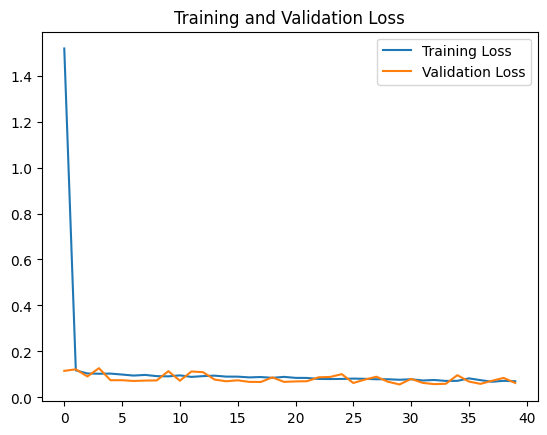

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

In [ ]:
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


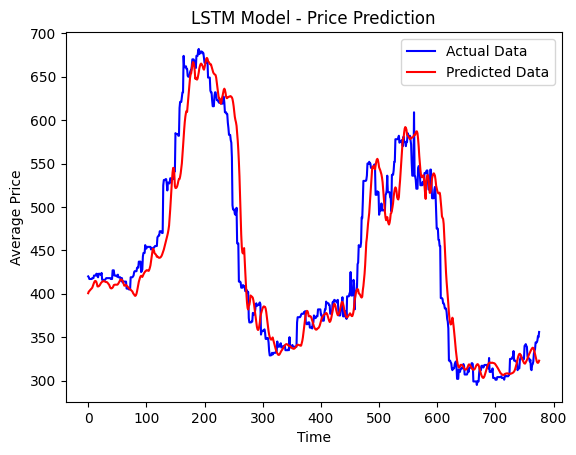

In [ ]:
import matplotlib.pyplot as plt

plt.plot(y_test_rescaled, color='blue', label='Actual Data')
plt.plot(y_pred_rescaled, color='red', label='Predicted Data')
plt.title('LSTM Model - Price Prediction')
plt.xlabel('Time')
plt.ylabel('Average Price')
plt.legend()
plt.show()

In [ ]:
num_features = 1  # 예측할 값이 하나 (평균 가격)

predicted_prices = []

# 현재 데이터를 시계열 입력 형식으로 변환 (현재 마지막 값 이후로 예측을 시작)
current_input = X_test[-1].reshape(1, time_step, num_features)

In [ ]:
# 30일 예측
future_days = 30  # 예측할 기간 설정

for _ in range(future_days):
    # 예측값을 얻음 (모델의 출력값은 (1, 1) 형태)
    next_day_pred = model.predict(current_input)

    # 예측값을 predicted_prices 리스트에 추가
    predicted_prices.append(next_day_pred[0, 0])

    # 예측값을 current_input에 추가하여, 다음 예측에 사용
    # 예측된 값을 current_input의 마지막 값에 추가하고, 가장 첫 값을 버림
    current_input = np.append(current_input[:, 1:, :], next_day_pred.reshape(1, 1, 1), axis=1)

# 예측된 30일 가격 출력
print("Predicted 30 days prices:", predicted_prices)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

In [ ]:
# 1D 배열을 2D 배열로 변환
predicted_prices = np.array(predicted_prices).reshape(-1, 1)
predicted_prices = scaler.inverse_transform(predicted_prices)

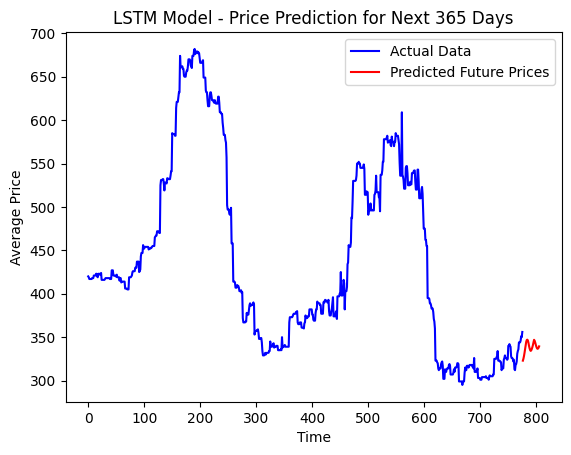

In [ ]:
plt.plot(range(len(y_test_rescaled)), y_test_rescaled, color='blue', label='Actual Data')
plt.plot(range(len(y_test_rescaled), len(y_test_rescaled) + future_days), predicted_prices, color='red', label='Predicted Future Prices')
plt.title('LSTM Model - Price Prediction for Next 365 Days')
plt.xlabel('Time')
plt.ylabel('Average Price')
plt.legend()
plt.show()

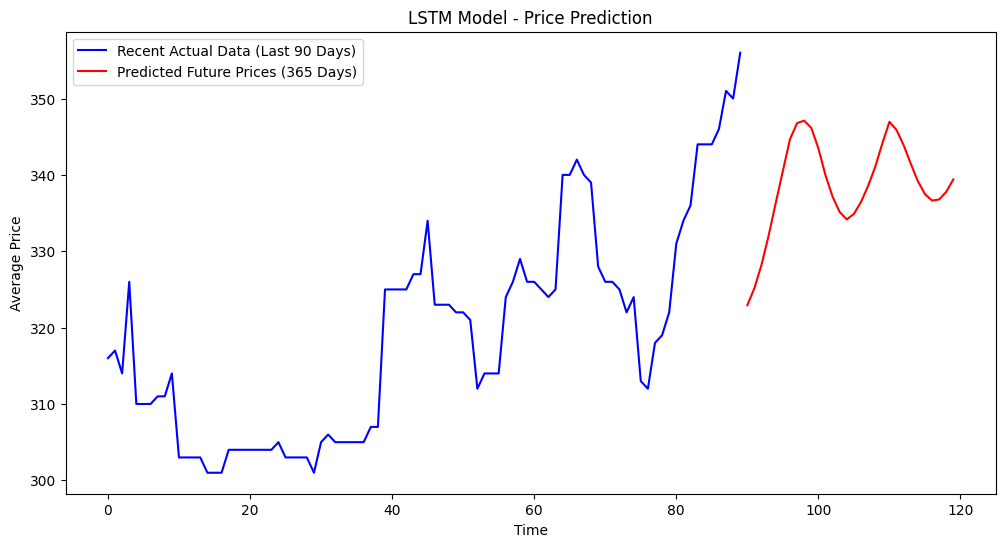

In [ ]:
recent_days = 90
recent_actual_data = y_test_rescaled[-recent_days:]  # 최근 90일 데이터

# x축 범위 생성
x_actual = range(len(recent_actual_data))  # 최근 데이터의 x축
x_predicted = range(len(recent_actual_data), len(recent_actual_data) + future_days)  # 예측 데이터의 x축

# 그래프 생성
plt.figure(figsize=(12, 6))
plt.plot(x_actual, recent_actual_data, color='blue', label='Recent Actual Data (Last 90 Days)')
plt.plot(x_predicted, predicted_prices, color='red', label='Predicted Future Prices (365 Days)')
plt.title('LSTM Model - Price Prediction')
plt.xlabel('Time')
plt.ylabel('Average Price')
plt.legend()
plt.show()

In [ ]:
from datetime import datetime, timedelta

potato=potato.reset_index()
potato['평균'].iloc[-1]
last_date = pd.to_datetime(potato['구분'].iloc[-1])  # Potato DataFrame에서 마지막 날짜 추출
last_price =potato['평균'].iloc[-1]  # Potato DataFrame에서 마지막 가격 추출

# 날짜 생성
future_dates = [last_date + timedelta(days=i+1) for i in range(len(predicted_prices))]

# DataFrame 생성

df_0 = pd.DataFrame({
    '날짜': [last_date],
    '예측가격': [last_price]
})
df_future = pd.DataFrame({
    '날짜': future_dates,
    '예측가격': predicted_prices.flatten()  # 배열을 1차원으로 변환
})

df_potato_extended=pd.concat([df_0, df_future], ignore_index=True)
df_potato_extended['품목'] = '감자'

# CSV로 저장
output_path = "potato_predictions.csv"
df_potato_extended.to_csv(output_path, index=False, encoding='cp949')

## ---------- 당근 상품 예측 모델링(LSTM) ----------

In [ ]:
carrot = pd.read_csv('/content/sample_data/품목_소매가_전부_갱신.csv', encoding='cp949')
carrot = carrot[carrot['품목']=='당근'].drop(columns='품목')  ### 추가, 변경
carrot.head()

,구분,평균,전통시장,유통업체
15916,2014-01-02,"2,625","2,866","2,490"
15917,2014-01-03,"2,606","2,866","2,460"
15918,2014-01-04,"2,606","2,866","2,460"
15919,2014-01-05,"2,606","2,866","2,460"
15920,2014-01-06,"2,663","2,845","2,560"


In [ ]:
carrot = carrot.drop(carrot.columns[2:], axis = 1)
carrot['평균'] = carrot['평균'].str.replace(',', '').astype(int)
carrot.head()

,구분,평균
15916,2014-01-02,2625
15917,2014-01-03,2606
15918,2014-01-04,2606
15919,2014-01-05,2606
15920,2014-01-06,2663


In [ ]:
carrot['구분'] = pd.to_datetime(carrot['구분'])
carrot.set_index('구분', inplace=True)
carrot = carrot[['평균']]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(carrot)
scaled_data = pd.DataFrame(scaled_data, columns=['평균'], index=carrot.index)

scaled_data

,평균
구분,
2014-01-02,0.103607
2014-01-03,0.100359
2014-01-04,0.100359
2014-01-05,0.100359
2014-01-06,0.110104
...,...
2024-11-29,0.799966
2024-12-02,0.809369
2024-12-03,0.809711


In [ ]:
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size

train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

def create_dataset(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data.iloc[i:i + time_step].values)  # time_step만큼의 데이터를 X로 사용
        y.append(data.iloc[i + time_step].values)  # 그 다음 시점의 데이터를 y로 사용
    return np.array(X), np.array(y)

# 시계열 데이터를 X, y 형식으로 변환
time_step = 18  # 시계열 길이(바꾸는 것)
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [ ]:
# 모델 구성
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

model = Sequential()

# 첫 번째 LSTM 층
model.add(LSTM(200, activation='tanh', return_sequences=True,
               kernel_regularizer=l2(0.01), input_shape=(X_train.shape[1], 1)))
# Dropout
model.add(Dropout(0.2))


# 두 번째 LSTM 층
model.add(LSTM(100, activation='tanh', return_sequences=True,
               kernel_regularizer=l2(0.01)))
# Dropout
model.add(Dropout(0.2))


# 세 번째 LSTM 층
model.add(LSTM(50, activation='tanh', return_sequences=True,
               kernel_regularizer=l2(0.01)))
# Dropout
model.add(Dropout(0.2))


# 네 번째 LSTM 층
model.add(LSTM(50, activation='tanh', return_sequences=True,
               kernel_regularizer=l2(0.01)))
# Dropout
model.add(Dropout(0.2))


# 마지막 LSTM 층
model.add(LSTM(100, activation='tanh', return_sequences=True,
               kernel_regularizer=l2(0.01)))
# Dropout
model.add(Dropout(0.2))

model.add(LSTM(200, activation='tanh', return_sequences=False,
               kernel_regularizer=l2(0.01)))
# Dropout
model.add(Dropout(0.2))


# 출력층 (예측할 값은 하나이므로 유닛 1)
model.add(Dense(1))

# 모델 요약
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                       │ (None, 18, 200)             │         161,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 18, 200)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_25 (LSTM)                       │ (None, 18, 100)             │         120,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 18, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_26 (LSTM)                       │ (None, 18, 50)              │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 18, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_27 (LSTM)                       │ (None, 18, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 18, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_28 (LSTM)                       │ (None, 18, 100)             │          60,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 18, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_29 (LSTM)                       │ (None, 200)                 │         240,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │             201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 633,801 (2.42 MB)

 Trainable params: 633,801 (2.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.00092), loss=rmse, metrics=['mae'])

# EarlyStopping 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size=25, # (바꾸는 것)
                    epochs=100,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

Epoch 1/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 4.0570 - mae: 0.0881 - val_loss: 0.3210 - val_mae: 0.0812
Epoch 2/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.2039 - mae: 0.0503 - val_loss: 0.1265 - val_mae: 0.0899
Epoch 3/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0865 - mae: 0.0456 - val_loss: 0.1060 - val_mae: 0.0829
Epoch 4/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0766 - mae: 0.0450 - val_loss: 0.0962 - val_mae: 0.0757
Epoch 5/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0754 - mae: 0.0465 - val_loss: 0.0962 - val_mae: 0.0774
Epoch 6/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0726 - mae: 0.0454 - val_loss: 0.0970 - val_mae: 0.0788
Epoch 7/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0732 - mae: 0.0463 - val_loss: 0.0939 - val_mae: 0.0766
Epoch 8/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0715 - mae: 0.0457 - val_loss: 0.0933 - val_mae: 0.0765
Epoch 9/100
127/127 ━━━━━━━━━━━━━━━━━━━━

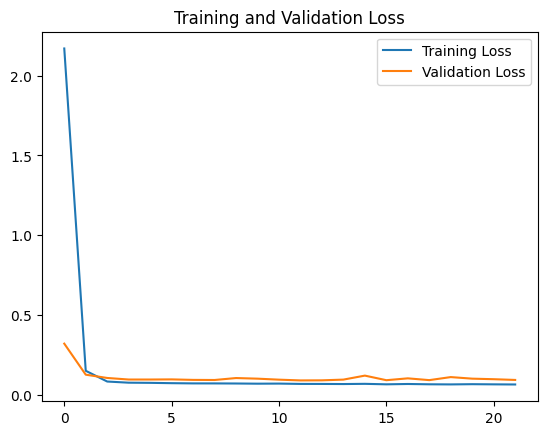

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

In [ ]:
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


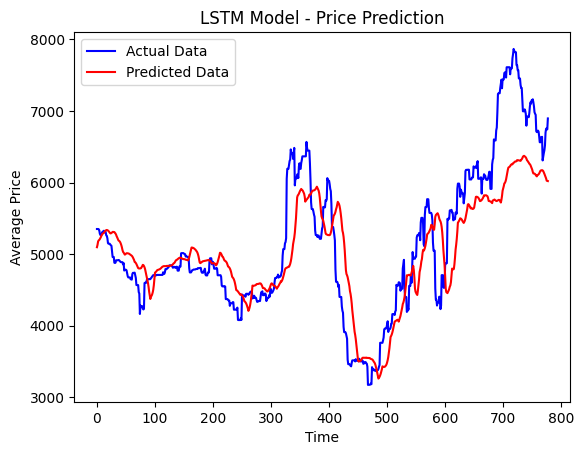

In [ ]:
import matplotlib.pyplot as plt

plt.plot(y_test_rescaled, color='blue', label='Actual Data')
plt.plot(y_pred_rescaled, color='red', label='Predicted Data')
plt.title('LSTM Model - Price Prediction')
plt.xlabel('Time')
plt.ylabel('Average Price')
plt.legend()
plt.show()

In [ ]:
num_features = 1  # 예측할 값이 하나 (평균 가격)

predicted_prices = []

# 현재 데이터를 시계열 입력 형식으로 변환 (현재 마지막 값 이후로 예측을 시작)
current_input = X_test[-1].reshape(1, time_step, num_features)

In [ ]:
# 30일 예측
future_days = 30  # 예측할 기간 설정

for _ in range(future_days):
    # 예측값을 얻음 (모델의 출력값은 (1, 1) 형태)
    next_day_pred = model.predict(current_input)

    # 예측값을 predicted_prices 리스트에 추가
    predicted_prices.append(next_day_pred[0, 0])

    # 예측값을 current_input에 추가하여, 다음 예측에 사용
    # 예측된 값을 current_input의 마지막 값에 추가하고, 가장 첫 값을 버림
    current_input = np.append(current_input[:, 1:, :], next_day_pred.reshape(1, 1, 1), axis=1)

# 예측된 30일 가격 출력
print("Predicted 30 days prices:", predicted_prices)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━

In [ ]:
# 1D 배열을 2D 배열로 변환
predicted_prices = np.array(predicted_prices).reshape(-1, 1)
predicted_prices = scaler.inverse_transform(predicted_prices)

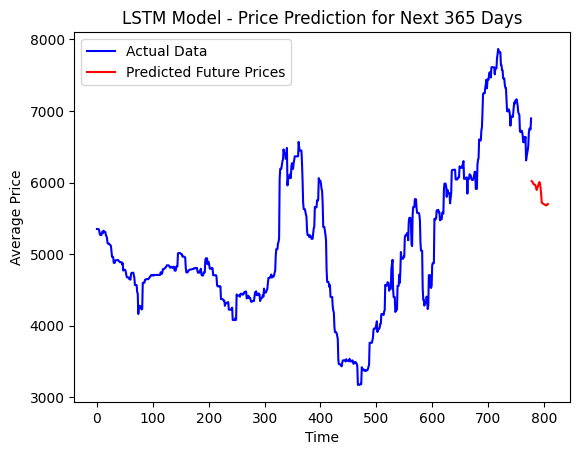

In [ ]:
plt.plot(range(len(y_test_rescaled)), y_test_rescaled, color='blue', label='Actual Data')
plt.plot(range(len(y_test_rescaled), len(y_test_rescaled) + future_days), predicted_prices, color='red', label='Predicted Future Prices')
plt.title('LSTM Model - Price Prediction for Next 365 Days')
plt.xlabel('Time')
plt.ylabel('Average Price')
plt.legend()
plt.show()

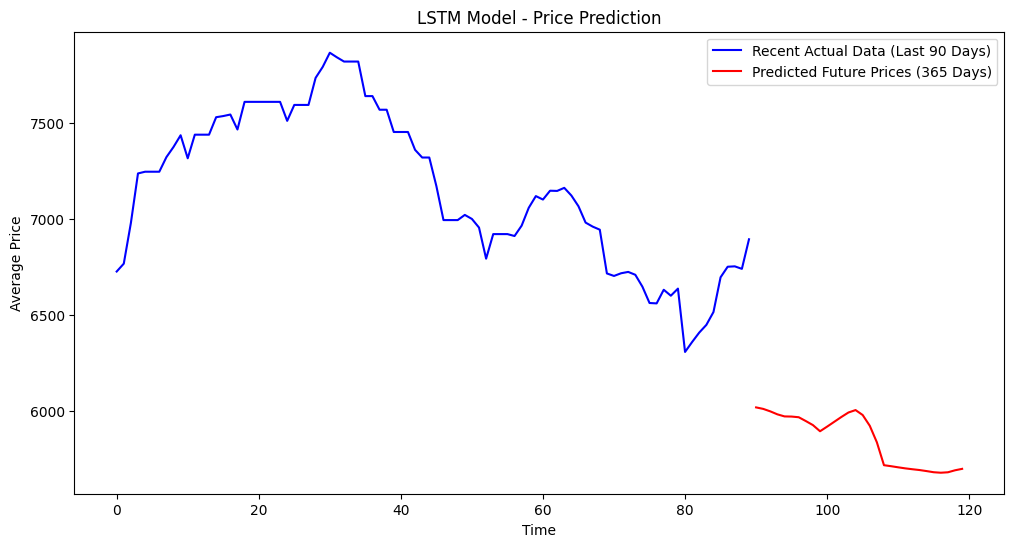

In [ ]:
recent_days = 90
recent_actual_data = y_test_rescaled[-recent_days:]  # 최근 90일 데이터

# x축 범위 생성
x_actual = range(len(recent_actual_data))  # 최근 데이터의 x축
x_predicted = range(len(recent_actual_data), len(recent_actual_data) + future_days)  # 예측 데이터의 x축

# 그래프 생성
plt.figure(figsize=(12, 6))
plt.plot(x_actual, recent_actual_data, color='blue', label='Recent Actual Data (Last 90 Days)')
plt.plot(x_predicted, predicted_prices, color='red', label='Predicted Future Prices (365 Days)')
plt.title('LSTM Model - Price Prediction')
plt.xlabel('Time')
plt.ylabel('Average Price')
plt.legend()
plt.show()

In [ ]:
from datetime import datetime, timedelta

carrot=carrot.reset_index()
carrot['평균'].iloc[-1]
last_date = pd.to_datetime(carrot['구분'].iloc[-1])  # carrot DataFrame에서 마지막 날짜 추출
last_price =carrot['평균'].iloc[-1]  # carrot DataFrame에서 마지막 가격 추출

# 날짜 생성
future_dates = [last_date + timedelta(days=i+1) for i in range(len(predicted_prices))]

# DataFrame 생성

df_0 = pd.DataFrame({
    '날짜': [last_date],
    '예측가격': [last_price]
})
df_future = pd.DataFrame({
    '날짜': future_dates,
    '예측가격': predicted_prices.flatten()  # 배열을 1차원으로 변환
})

df_carrot_extended=pd.concat([df_0, df_future], ignore_index=True)
df_carrot_extended['품목'] = '당근'

# CSV로 저장
output_path = "carrot_predictions.csv"
df_carrot_extended.to_csv(output_path, index=False, encoding='cp949')

## ------------ 무 가격 예측 모델링(LSTM) ---------------

In [ ]:
daicon = pd.read_csv('/content/sample_data/품목_소매가_전부_갱신.csv', encoding='cp949') ### 추가, 변경
daicon = daicon[daicon['품목']=='무'].drop(columns='품목')  ### 추가, 변경

daicon.head()

,구분,평균,전통시장,유통업체
23874,2014-01-02,1358.0,1520.0,1262
23875,2014-01-03,1358.0,1520.0,1262
23876,2014-01-04,1358.0,1520.0,1262
23877,2014-01-05,1358.0,1520.0,1262
23878,2014-01-06,1445.0,1520.0,1397


In [ ]:
daicon = daicon.drop(daicon.columns[2:], axis = 1)
daicon['평균'] = daicon['평균'].str.replace(',', '').astype(float)
daicon.head()

,구분,평균
23874,2014-01-02,1358.0
23875,2014-01-03,1358.0
23876,2014-01-04,1358.0
23877,2014-01-05,1358.0
23878,2014-01-06,1445.0


In [ ]:
daicon['구분'] = pd.to_datetime(daicon['구분'])
daicon.set_index('구분', inplace=True)
daicon = daicon[['평균']]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(daicon)
scaled_data = pd.DataFrame(scaled_data, columns=['평균'], index=daicon.index)

scaled_data

,평균
구분,
2014-01-02,0.108101
2014-01-03,0.108101
2014-01-04,0.108101
2014-01-05,0.108101
2014-01-06,0.132402
...,...
2024-11-29,0.520391
2024-12-02,0.564804
2024-12-03,0.579050


In [ ]:
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size

train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

def create_dataset(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data.iloc[i:i + time_step].values)  # time_step만큼의 데이터를 X로 사용
        y.append(data.iloc[i + time_step].values)  # 그 다음 시점의 데이터를 y로 사용
    return np.array(X), np.array(y)

# 시계열 데이터를 X, y 형식으로 변환
time_step = 30  # 시계열 길이(바꾸는 것)
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [ ]:
# 모델 구성
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

model = Sequential()

# 첫 번째 LSTM 층
model.add(LSTM(200, activation='tanh', return_sequences=True,
               kernel_regularizer=l2(0.01), input_shape=(X_train.shape[1], 1)))
# Dropout
model.add(Dropout(0.2))


# 두 번째 LSTM 층
model.add(LSTM(100, activation='tanh', return_sequences=True,
               kernel_regularizer=l2(0.01)))
# Dropout
model.add(Dropout(0.2))


# 세 번째 LSTM 층
model.add(LSTM(50, activation='tanh', return_sequences=True,
               kernel_regularizer=l2(0.01)))
# Dropout
model.add(Dropout(0.2))


# 네 번째 LSTM 층
model.add(LSTM(50, activation='tanh', return_sequences=True,
               kernel_regularizer=l2(0.01)))
# Dropout
model.add(Dropout(0.2))


# 마지막 LSTM 층
model.add(LSTM(100, activation='tanh', return_sequences=True,
               kernel_regularizer=l2(0.01)))
# Dropout
model.add(Dropout(0.2))

model.add(LSTM(200, activation='tanh', return_sequences=False,
               kernel_regularizer=l2(0.01)))
# Dropout
model.add(Dropout(0.2))


# 출력층 (예측할 값은 하나이므로 유닛 1)
model.add(Dense(1))

# 모델 요약
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_36 (LSTM)                       │ (None, 30, 200)             │         161,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 30, 200)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_37 (LSTM)                       │ (None, 30, 100)             │         120,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_37 (Dropout)                 │ (None, 30, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_38 (LSTM)                       │ (None, 30, 50)              │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_38 (Dropout)                 │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_39 (LSTM)                       │ (None, 30, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_39 (Dropout)                 │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_40 (LSTM)                       │ (None, 30, 100)             │          60,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_40 (Dropout)                 │ (None, 30, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_41 (LSTM)                       │ (None, 200)                 │         240,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_41 (Dropout)                 │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │             201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 633,801 (2.42 MB)

 Trainable params: 633,801 (2.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.0029), loss=rmse, metrics=['mae'])

# EarlyStopping 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size=50, # (바꾸는 것)
                    epochs=100,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 3.4122 - mae: 0.1621 - val_loss: 0.2356 - val_mae: 0.1380
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.1802 - mae: 0.0974 - val_loss: 0.1507 - val_mae: 0.1149
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.1457 - mae: 0.0905 - val_loss: 0.1626 - val_mae: 0.1217
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1286 - mae: 0.0740 - val_loss: 0.1617 - val_mae: 0.1146
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1268 - mae: 0.0724 - val_loss: 0.1244 - val_mae: 0.0806
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1131 - mae: 0.0643 - val_loss: 0.1484 - val_mae: 0.0968
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1096 - mae: 0.0608 - val_loss: 0.1156 - val_mae: 0.0695
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1013 - mae: 0.0558 - val_loss: 0.1146 - val_mae: 0.0673
Epoch 9/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - lo

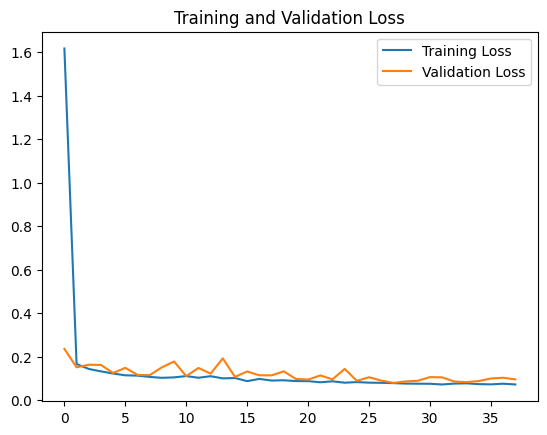

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

In [ ]:
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


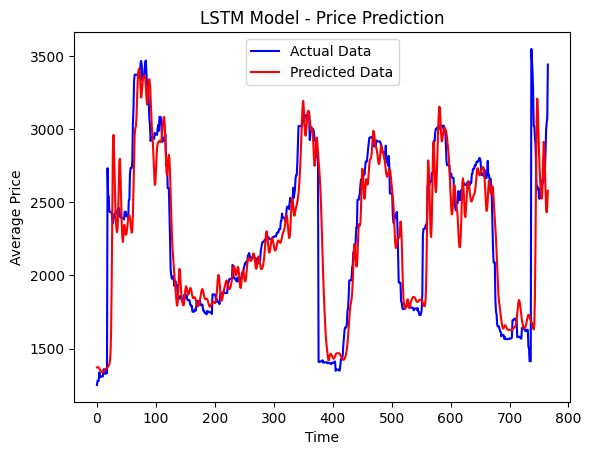

In [ ]:
import matplotlib.pyplot as plt

plt.plot(y_test_rescaled, color='blue', label='Actual Data')
plt.plot(y_pred_rescaled, color='red', label='Predicted Data')
plt.title('LSTM Model - Price Prediction')
plt.xlabel('Time')
plt.ylabel('Average Price')
plt.legend()
plt.show()

In [ ]:
num_features = 1  # 예측할 값이 하나 (평균 가격)

predicted_prices = []

# 현재 데이터를 시계열 입력 형식으로 변환 (현재 마지막 값 이후로 예측을 시작)
current_input = X_test[-1].reshape(1, time_step, num_features)

In [ ]:
# 30일 예측
future_days = 30  # 예측할 기간 설정

for _ in range(future_days):
    # 예측값을 얻음 (모델의 출력값은 (1, 1) 형태)
    next_day_pred = model.predict(current_input)

    # 예측값을 predicted_prices 리스트에 추가
    predicted_prices.append(next_day_pred[0, 0])

    # 예측값을 current_input에 추가하여, 다음 예측에 사용
    # 예측된 값을 current_input의 마지막 값에 추가하고, 가장 첫 값을 버림
    current_input = np.append(current_input[:, 1:, :], next_day_pred.reshape(1, 1, 1), axis=1)

# 예측된 30일 가격 출력
print("Predicted 30 days prices:", predicted_prices)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

In [ ]:
# 1D 배열을 2D 배열로 변환
predicted_prices = np.array(predicted_prices).reshape(-1, 1)
predicted_prices = scaler.inverse_transform(predicted_prices)

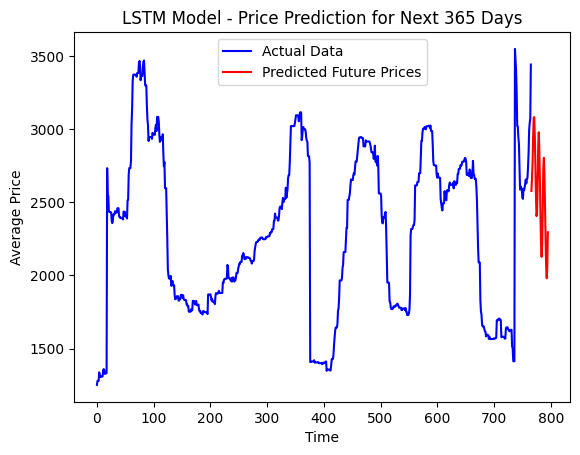

In [ ]:
plt.plot(range(len(y_test_rescaled)), y_test_rescaled, color='blue', label='Actual Data')
plt.plot(range(len(y_test_rescaled), len(y_test_rescaled) + future_days), predicted_prices, color='red', label='Predicted Future Prices')
plt.title('LSTM Model - Price Prediction for Next 365 Days')
plt.xlabel('Time')
plt.ylabel('Average Price')
plt.legend()
plt.show()

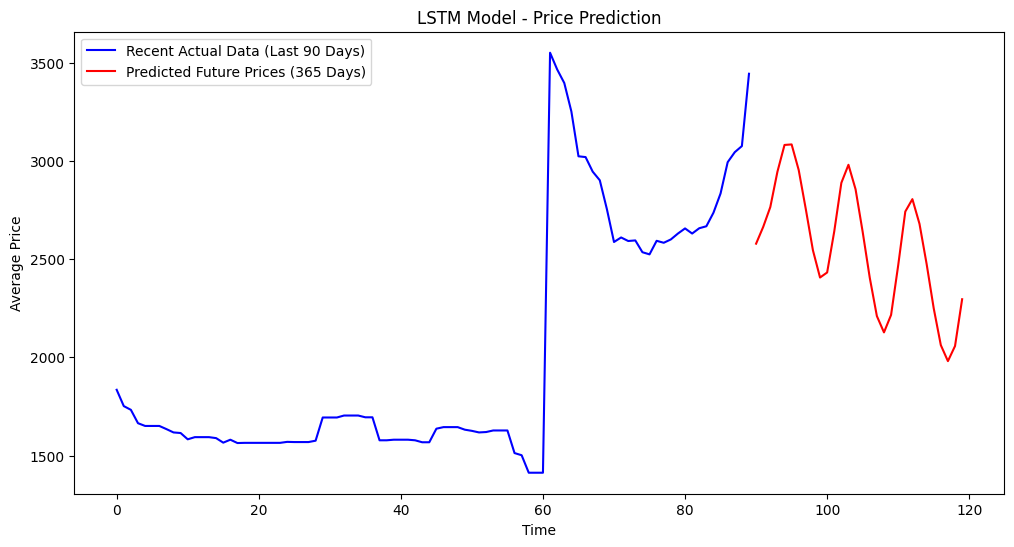

In [ ]:
recent_days = 90
recent_actual_data = y_test_rescaled[-recent_days:]  # 최근 90일 데이터

# x축 범위 생성
x_actual = range(len(recent_actual_data))  # 최근 데이터의 x축
x_predicted = range(len(recent_actual_data), len(recent_actual_data) + future_days)  # 예측 데이터의 x축

# 그래프 생성
plt.figure(figsize=(12, 6))
plt.plot(x_actual, recent_actual_data, color='blue', label='Recent Actual Data (Last 90 Days)')
plt.plot(x_predicted, predicted_prices, color='red', label='Predicted Future Prices (365 Days)')
plt.title('LSTM Model - Price Prediction')
plt.xlabel('Time')
plt.ylabel('Average Price')
plt.legend()
plt.show()

In [ ]:
from datetime import datetime, timedelta

daicon=daicon.reset_index()
daicon['평균'].iloc[-1]
last_date = pd.to_datetime(daicon['구분'].iloc[-1])  # Potato DataFrame에서 마지막 날짜 추출
last_price =daicon['평균'].iloc[-1]  # Potato DataFrame에서 마지막 가격 추출

# 날짜 생성
future_dates = [last_date + timedelta(days=i+1) for i in range(len(predicted_prices))]

# DataFrame 생성

df_0 = pd.DataFrame({
    '날짜': [last_date],
    '예측가격': [last_price]
})
df_future = pd.DataFrame({
    '날짜': future_dates,
    '예측가격': predicted_prices.flatten()  # 배열을 1차원으로 변환
})

df_daicon_extended=pd.concat([df_0, df_future], ignore_index=True)
df_daicon_extended['품목'] = '무'

# CSV로 저장
output_path = "daicon_predictions.csv"
df_daicon_extended.to_csv(output_path, index=False, encoding='cp949')


## -------------- 배추 LSTM ----------------

In [ ]:
baechu = pd.read_csv('/content/sample_data/품목_소매가_전부_갱신.csv', encoding='cp949')
baechu = baechu[baechu['품목']=='배추'].drop(columns='품목')  ### 추가, 변경

baechu.head()

,구분,평균,전통시장,유통업체
27853,2014-01-02,"2,515","2,628","2,148"
27854,2014-01-03,"2,515","2,628","2,148"
27855,2014-01-04,"2,515","2,628","2,148"
27856,2014-01-05,"2,515","2,628","2,148"
27857,2014-01-06,"2,530","2,617","2,098"


In [ ]:
baechu = baechu.drop(baechu.columns[2:], axis = 1)
baechu['평균'] = baechu['평균'].str.replace(',', '').astype(int)
baechu.head()

,구분,평균
27853,2014-01-02,2515
27854,2014-01-03,2515
27855,2014-01-04,2515
27856,2014-01-05,2515
27857,2014-01-06,2530


In [ ]:
baechu['구분'] = pd.to_datetime(baechu['구분'])
baechu.set_index('구분', inplace=True)
baechu = baechu[['평균']]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(baechu)
scaled_data = pd.DataFrame(scaled_data, columns=['평균'], index=baechu.index)

scaled_data

,평균
구분,
2014-01-02,0.090918
2014-01-03,0.090918
2014-01-04,0.090918
2014-01-05,0.090918
2014-01-06,0.092363
...,...
2024-11-29,0.161032
2024-12-02,0.183666
2024-12-03,0.178176


In [ ]:
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size

train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

def create_dataset(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data.iloc[i:i + time_step].values)  # time_step만큼의 데이터를 X로 사용
        y.append(data.iloc[i + time_step].values)  # 그 다음 시점의 데이터를 y로 사용
    return np.array(X), np.array(y)

# 시계열 데이터를 X, y 형식으로 변환
time_step = 25  # 시계열 길이(바꾸는 것)
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [ ]:
# 모델 구성
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

model = Sequential()

# 첫 번째 LSTM 층
model.add(LSTM(200, activation='tanh', return_sequences=True,
               kernel_regularizer=l2(0.01), input_shape=(X_train.shape[1], 1)))
# Dropout
model.add(Dropout(0.2))


# 두 번째 LSTM 층
model.add(LSTM(100, activation='tanh', return_sequences=True,
               kernel_regularizer=l2(0.01)))
# Dropout
model.add(Dropout(0.2))


# 세 번째 LSTM 층
model.add(LSTM(50, activation='tanh', return_sequences=True,
               kernel_regularizer=l2(0.01)))
# Dropout
model.add(Dropout(0.2))


# 네 번째 LSTM 층
model.add(LSTM(50, activation='tanh', return_sequences=True,
               kernel_regularizer=l2(0.01)))
# Dropout
model.add(Dropout(0.2))


# 마지막 LSTM 층
model.add(LSTM(100, activation='tanh', return_sequences=True,
               kernel_regularizer=l2(0.01)))
# Dropout
model.add(Dropout(0.2))

model.add(LSTM(200, activation='tanh', return_sequences=False,
               kernel_regularizer=l2(0.01)))
# Dropout
model.add(Dropout(0.2))


# 출력층 (예측할 값은 하나이므로 유닛 1)
model.add(Dense(1))

# 모델 요약
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_42 (LSTM)                       │ (None, 25, 200)             │         161,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_42 (Dropout)                 │ (None, 25, 200)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_43 (LSTM)                       │ (None, 25, 100)             │         120,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_43 (Dropout)                 │ (None, 25, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_44 (LSTM)                       │ (None, 25, 50)              │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_44 (Dropout)                 │ (None, 25, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_45 (LSTM)                       │ (None, 25, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_45 (Dropout)                 │ (None, 25, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_46 (LSTM)                       │ (None, 25, 100)             │          60,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_46 (Dropout)                 │ (None, 25, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_47 (LSTM)                       │ (None, 200)                 │         240,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_47 (Dropout)                 │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 633,801 (2.42 MB)

 Trainable params: 633,801 (2.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.0027), loss=rmse, metrics=['mae'])

# EarlyStopping 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size=50, # (바꾸는 것)
                    epochs=100,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 3.3612 - mae: 0.1180 - val_loss: 0.1411 - val_mae: 0.0981
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.1325 - mae: 0.0775 - val_loss: 0.1463 - val_mae: 0.1228
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.1297 - mae: 0.0828 - val_loss: 0.1055 - val_mae: 0.0822
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.1235 - mae: 0.0762 - val_loss: 0.1444 - val_mae: 0.1178
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1167 - mae: 0.0731 - val_loss: 0.1083 - val_mae: 0.0853
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1158 - mae: 0.0715 - val_loss: 0.1072 - val_mae: 0.0799
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1076 - mae: 0.0635 - val_loss: 0.1316 - val_mae: 0.1086
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1115 - mae: 0.0692 - val_loss: 0.0991 - val_mae: 0.0753
Epoch 9/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - lo

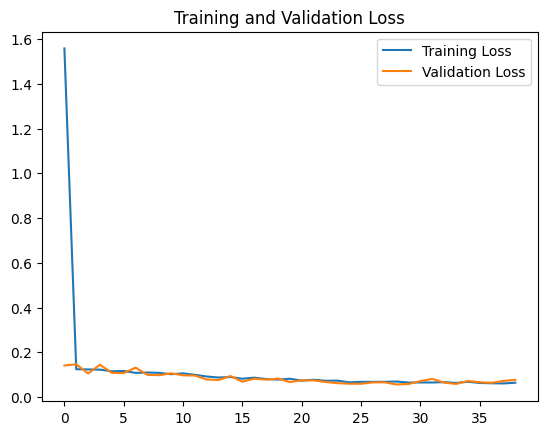

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

In [ ]:
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


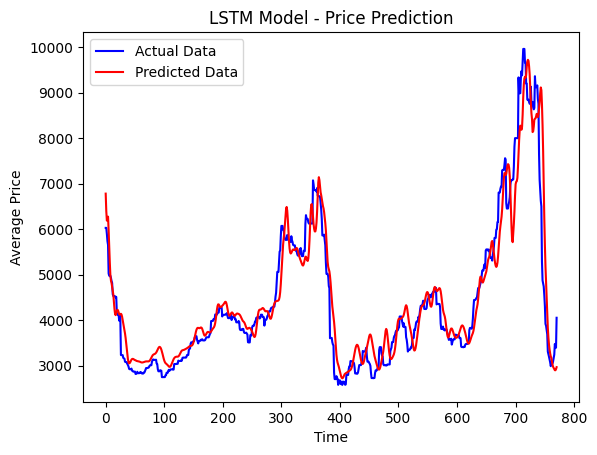

In [ ]:
import matplotlib.pyplot as plt

plt.plot(y_test_rescaled, color='blue', label='Actual Data')
plt.plot(y_pred_rescaled, color='red', label='Predicted Data')
plt.title('LSTM Model - Price Prediction')
plt.xlabel('Time')
plt.ylabel('Average Price')
plt.legend()
plt.show()

In [ ]:
num_features = 1  # 예측할 값이 하나 (평균 가격)

predicted_prices = []

# 현재 데이터를 시계열 입력 형식으로 변환 (현재 마지막 값 이후로 예측을 시작)
current_input = X_test[-1].reshape(1, time_step, num_features)

In [ ]:
# 30일 예측
future_days = 30  # 예측할 기간 설정

for _ in range(future_days):
    # 예측값을 얻음 (모델의 출력값은 (1, 1) 형태)
    next_day_pred = model.predict(current_input)

    # 예측값을 predicted_prices 리스트에 추가
    predicted_prices.append(next_day_pred[0, 0])

    # 예측값을 current_input에 추가하여, 다음 예측에 사용
    # 예측된 값을 current_input의 마지막 값에 추가하고, 가장 첫 값을 버림
    current_input = np.append(current_input[:, 1:, :], next_day_pred.reshape(1, 1, 1), axis=1)

# 예측된 30일 가격 출력
print("Predicted 30 days prices:", predicted_prices)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

In [ ]:
# 1D 배열을 2D 배열로 변환
predicted_prices = np.array(predicted_prices).reshape(-1, 1)
predicted_prices = scaler.inverse_transform(predicted_prices)

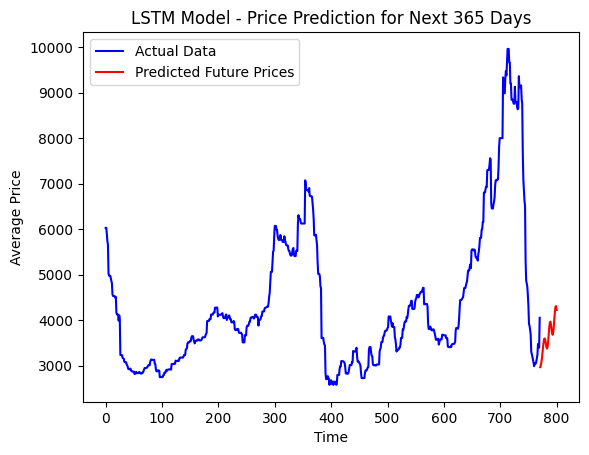

In [ ]:
plt.plot(range(len(y_test_rescaled)), y_test_rescaled, color='blue', label='Actual Data')
plt.plot(range(len(y_test_rescaled), len(y_test_rescaled) + future_days), predicted_prices, color='red', label='Predicted Future Prices')
plt.title('LSTM Model - Price Prediction for Next 365 Days')
plt.xlabel('Time')
plt.ylabel('Average Price')
plt.legend()
plt.show()

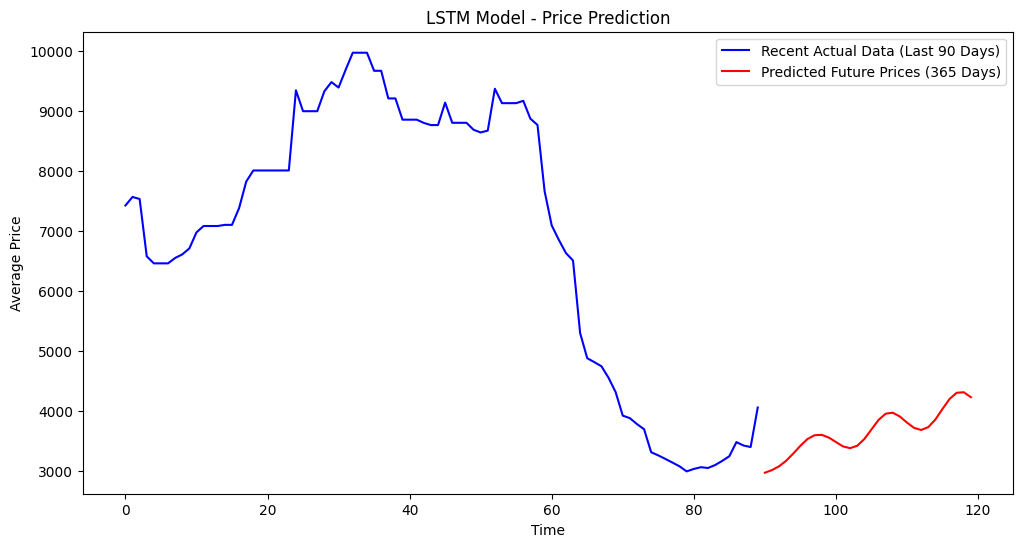

In [ ]:
recent_days = 90
recent_actual_data = y_test_rescaled[-recent_days:]  # 최근 90일 데이터

# x축 범위 생성
x_actual = range(len(recent_actual_data))  # 최근 데이터의 x축
x_predicted = range(len(recent_actual_data), len(recent_actual_data) + future_days)  # 예측 데이터의 x축

# 그래프 생성
plt.figure(figsize=(12, 6))
plt.plot(x_actual, recent_actual_data, color='blue', label='Recent Actual Data (Last 90 Days)')
plt.plot(x_predicted, predicted_prices, color='red', label='Predicted Future Prices (365 Days)')
plt.title('LSTM Model - Price Prediction')
plt.xlabel('Time')
plt.ylabel('Average Price')
plt.legend()
plt.show()

In [ ]:
from datetime import datetime, timedelta

baechu=baechu.reset_index()
baechu['평균'].iloc[-1]
last_date = pd.to_datetime(baechu['구분'].iloc[-1])  # Potato DataFrame에서 마지막 날짜 추출
last_price =baechu['평균'].iloc[-1]  # Potato DataFrame에서 마지막 가격 추출

# 날짜 생성
future_dates = [last_date + timedelta(days=i+1) for i in range(len(predicted_prices))]

# DataFrame 생성

df_0 = pd.DataFrame({
    '날짜': [last_date],
    '예측가격': [last_price]
})
df_future = pd.DataFrame({
    '날짜': future_dates,
    '예측가격': predicted_prices.flatten()  # 배열을 1차원으로 변환
})

df_baechu_extended=pd.concat([df_0, df_future], ignore_index=True)
df_baechu_extended['품목'] = '배추'

# CSV로 저장
output_path = "baechu_predictions.csv"
df_baechu_extended.to_csv(output_path, index=False, encoding='cp949')


## --------------  건고추 LSTM -------------------

In [ ]:
pepper = pd.read_csv('/content/sample_data/품목_소매가_전부_갱신.csv', encoding='cp949') ### 추가, 변경
pepper = pepper[pepper['품목']=='건고추'].drop(columns='품목')  ### 추가, 변경
pepper.head()

,구분,평균,전통시장,유통업체
3979,2014-01-02,10018.0,10018.0,-
3980,2014-01-03,10018.0,10018.0,-
3981,2014-01-04,10018.0,10018.0,-
3982,2014-01-05,10018.0,10018.0,-
3983,2014-01-06,10018.0,10018.0,-


In [ ]:
pepper = pepper.drop(pepper.columns[2:], axis = 1)
pepper['평균'] = pepper['평균'].str.replace(',', '').astype(float)
pepper.head()

,구분,평균
3979,2014-01-02,10018.0
3980,2014-01-03,10018.0
3981,2014-01-04,10018.0
3982,2014-01-05,10018.0
3983,2014-01-06,10018.0


In [ ]:
pepper['구분'] = pd.to_datetime(pepper['구분'])
pepper.set_index('구분', inplace=True)
pepper = pepper[['평균']]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(pepper)
scaled_data = pd.DataFrame(scaled_data, columns=['평균'], index=pepper.index)

scaled_data

,평균
구분,
2014-01-02,0.023527
2014-01-03,0.023527
2014-01-04,0.023527
2014-01-05,0.023527
2014-01-06,0.023527
...,...
2024-11-29,0.710843
2024-12-02,0.710518
2024-12-03,0.691062


In [ ]:
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size

train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

def create_dataset(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data.iloc[i:i + time_step].values)  # time_step만큼의 데이터를 X로 사용
        y.append(data.iloc[i + time_step].values)  # 그 다음 시점의 데이터를 y로 사용
    return np.array(X), np.array(y)

# 시계열 데이터를 X, y 형식으로 변환
time_step = 20  # 시계열 길이(바꾸는 것)
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [ ]:
# 모델 구성
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

model = Sequential()

# 첫 번째 LSTM 층
model.add(LSTM(100, activation='tanh', return_sequences=True,
               kernel_regularizer=l2(0.01), input_shape=(X_train.shape[1], 1)))
# Dropout
model.add(Dropout(0.2))


# 두 번째 LSTM 층
model.add(LSTM(100, activation='tanh', return_sequences=True,
               kernel_regularizer=l2(0.01)))
# Dropout
model.add(Dropout(0.2))


# 세 번째 LSTM 층
model.add(LSTM(50, activation='tanh', return_sequences=True,
               kernel_regularizer=l2(0.01)))
# Dropout
model.add(Dropout(0.2))


# 네 번째 LSTM 층
model.add(LSTM(50, activation='tanh', return_sequences=True,
               kernel_regularizer=l2(0.01)))
# Dropout
model.add(Dropout(0.2))


# 마지막 LSTM 층
model.add(LSTM(100, activation='tanh', return_sequences=True,
               kernel_regularizer=l2(0.01)))
# Dropout
model.add(Dropout(0.2))

model.add(LSTM(200, activation='tanh', return_sequences=False,
               kernel_regularizer=l2(0.01)))
# Dropout
model.add(Dropout(0.2))


# 출력층 (예측할 값은 하나이므로 유닛 1)
model.add(Dense(1))

# 모델 요약
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_48 (LSTM)                       │ (None, 20, 100)             │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_48 (Dropout)                 │ (None, 20, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_49 (LSTM)                       │ (None, 20, 100)             │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_49 (Dropout)                 │ (None, 20, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_50 (LSTM)                       │ (None, 20, 50)              │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_50 (Dropout)                 │ (None, 20, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_51 (LSTM)                       │ (None, 20, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_51 (Dropout)                 │ (None, 20, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_52 (LSTM)                       │ (None, 20, 100)             │          60,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_52 (Dropout)                 │ (None, 20, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_53 (LSTM)                       │ (None, 200)                 │         240,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_53 (Dropout)                 │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │             201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 473,001 (1.80 MB)

 Trainable params: 473,001 (1.80 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.0021), loss=rmse, metrics=['mae'])

# EarlyStopping 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size=50, # (바꾸는 것)
                    epochs=100,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 3.4661 - mae: 0.1487 - val_loss: 0.2282 - val_mae: 0.0260
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.2091 - mae: 0.0488 - val_loss: 0.0785 - val_mae: 0.0183
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1271 - mae: 0.0536 - val_loss: 0.0576 - val_mae: 0.0195
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1002 - mae: 0.0460 - val_loss: 0.0566 - val_mae: 0.0262
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1069 - mae: 0.0557 - val_loss: 0.1394 - val_mae: 0.1159
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1139 - mae: 0.0655 - val_loss: 0.0577 - val_mae: 0.0319
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0901 - mae: 0.0459 - val_loss: 0.1511 - val_mae: 0.1288
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1093 - mae: 0.0662 - val_loss: 0.0524 - val_mae: 0.0293
Epoch 9/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - lo

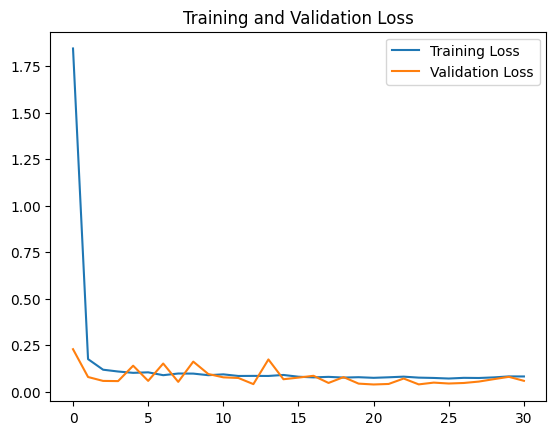

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

In [ ]:
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


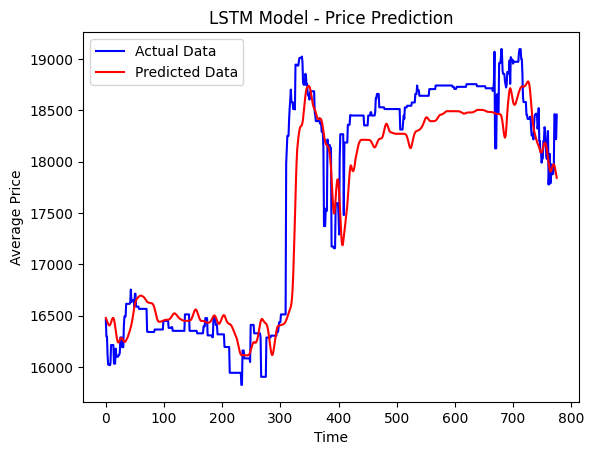

In [ ]:
import matplotlib.pyplot as plt

plt.plot(y_test_rescaled, color='blue', label='Actual Data')
plt.plot(y_pred_rescaled, color='red', label='Predicted Data')
plt.title('LSTM Model - Price Prediction')
plt.xlabel('Time')
plt.ylabel('Average Price')
plt.legend()
plt.show()

In [ ]:
num_features = 1  # 예측할 값이 하나 (평균 가격)

predicted_prices = []

# 현재 데이터를 시계열 입력 형식으로 변환 (현재 마지막 값 이후로 예측을 시작)
current_input = X_test[-1].reshape(1, time_step, num_features)

In [ ]:
# 30일 예측
future_days = 30  # 예측할 기간 설정

for _ in range(future_days):
    # 예측값을 얻음 (모델의 출력값은 (1, 1) 형태)
    next_day_pred = model.predict(current_input)

    # 예측값을 predicted_prices 리스트에 추가
    predicted_prices.append(next_day_pred[0, 0])

    # 예측값을 current_input에 추가하여, 다음 예측에 사용
    # 예측된 값을 current_input의 마지막 값에 추가하고, 가장 첫 값을 버림
    current_input = np.append(current_input[:, 1:, :], next_day_pred.reshape(1, 1, 1), axis=1)

# 예측된 30일 가격 출력
print("Predicted 30 days prices:", predicted_prices)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

In [ ]:
# 1D 배열을 2D 배열로 변환
predicted_prices = np.array(predicted_prices).reshape(-1, 1)
predicted_prices = scaler.inverse_transform(predicted_prices)

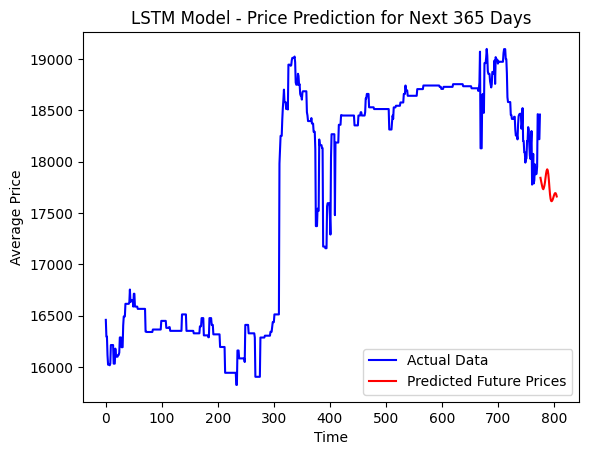

In [ ]:
plt.plot(range(len(y_test_rescaled)), y_test_rescaled, color='blue', label='Actual Data')
plt.plot(range(len(y_test_rescaled), len(y_test_rescaled) + future_days), predicted_prices, color='red', label='Predicted Future Prices')
plt.title('LSTM Model - Price Prediction for Next 365 Days')
plt.xlabel('Time')
plt.ylabel('Average Price')
plt.legend()
plt.show()

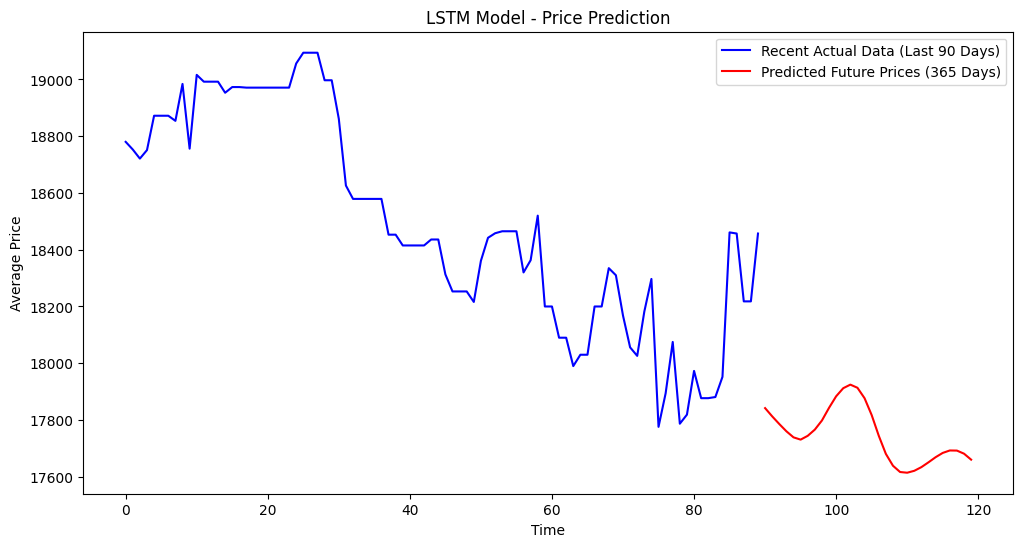

In [ ]:
recent_days = 90
recent_actual_data = y_test_rescaled[-recent_days:]  # 최근 90일 데이터

# x축 범위 생성
x_actual = range(len(recent_actual_data))  # 최근 데이터의 x축
x_predicted = range(len(recent_actual_data), len(recent_actual_data) + future_days)  # 예측 데이터의 x축

# 그래프 생성
plt.figure(figsize=(12, 6))
plt.plot(x_actual, recent_actual_data, color='blue', label='Recent Actual Data (Last 90 Days)')
plt.plot(x_predicted, predicted_prices, color='red', label='Predicted Future Prices (365 Days)')
plt.title('LSTM Model - Price Prediction')
plt.xlabel('Time')
plt.ylabel('Average Price')
plt.legend()
plt.show()

In [ ]:
from datetime import datetime, timedelta

pepper=pepper.reset_index()
pepper['평균'].iloc[-1]
last_date = pd.to_datetime(pepper['구분'].iloc[-1])  # Potato DataFrame에서 마지막 날짜 추출
last_price =pepper['평균'].iloc[-1]  # Potato DataFrame에서 마지막 가격 추출

# 날짜 생성
future_dates = [last_date + timedelta(days=i+1) for i in range(len(predicted_prices))]

# DataFrame 생성

df_0 = pd.DataFrame({
    '날짜': [last_date],
    '예측가격': [last_price]
})
df_future = pd.DataFrame({
    '날짜': future_dates,
    '예측가격': predicted_prices.flatten()  # 배열을 1차원으로 변환
})

df_pepper_extended=pd.concat([df_0, df_future], ignore_index=True)
df_pepper_extended['품목'] = '건고추'

# CSV로 저장
output_path = "pepper_predictions.csv"
df_pepper_extended.to_csv(output_path, index=False, encoding='cp949')

## --------- 고구마 LSTM ------------------

In [ ]:
sweetpotato = pd.read_csv('/content/sample_data/품목_소매가_전부_갱신.csv', encoding='cp949')
sweetpotato = sweetpotato[sweetpotato['품목']=='고구마'].drop(columns='품목')  ### 추가, 변경

sweetpotato.head()

,구분,평균,전통시장,유통업체
7958,2014-01-02,"3,717","3,475","3,871"
7959,2014-01-03,"3,816","3,475","4,024"
7960,2014-01-04,"3,816","3,475","4,024"
7961,2014-01-05,"3,816","3,475","4,024"
7962,2014-01-06,"3,895","3,475","4,140"


In [ ]:
sweetpotato = sweetpotato.drop(sweetpotato.columns[2:], axis = 1)
sweetpotato['평균'] = sweetpotato['평균'].str.replace(',', '').astype(float)
sweetpotato.head()

,구분,평균
7958,2014-01-02,3717.0
7959,2014-01-03,3816.0
7960,2014-01-04,3816.0
7961,2014-01-05,3816.0
7962,2014-01-06,3895.0


In [ ]:
sweetpotato['구분'] = pd.to_datetime(sweetpotato['구분'])
sweetpotato.set_index('구분', inplace=True)
sweetpotato = sweetpotato[['평균']]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(sweetpotato)
scaled_data = pd.DataFrame(scaled_data, columns=['평균'], index=sweetpotato.index)

scaled_data

,평균
구분,
2014-01-02,0.077055
2014-01-03,0.095937
2014-01-04,0.095937
2014-01-05,0.095937
2014-01-06,0.111005
...,...
2024-11-29,0.316231
2024-12-02,0.376693
2024-12-03,0.382415


In [ ]:
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size

train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

def create_dataset(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data.iloc[i:i + time_step].values)  # time_step만큼의 데이터를 X로 사용
        y.append(data.iloc[i + time_step].values)  # 그 다음 시점의 데이터를 y로 사용
    return np.array(X), np.array(y)

# 시계열 데이터를 X, y 형식으로 변환
time_step = 20  # 시계열 길이(바꾸는 것)
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [ ]:
# 모델 구성
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

model = Sequential()

# 첫 번째 LSTM 층
model.add(LSTM(200, activation='tanh', return_sequences=True,
               kernel_regularizer=l2(0.01), input_shape=(X_train.shape[1], 1)))
# Dropout
model.add(Dropout(0.2))


# 두 번째 LSTM 층
model.add(LSTM(100, activation='tanh', return_sequences=True,
               kernel_regularizer=l2(0.01)))
# Dropout
model.add(Dropout(0.2))


# 세 번째 LSTM 층
model.add(LSTM(50, activation='tanh', return_sequences=True,
               kernel_regularizer=l2(0.01)))
# Dropout
model.add(Dropout(0.2))


# 네 번째 LSTM 층
model.add(LSTM(50, activation='tanh', return_sequences=True,
               kernel_regularizer=l2(0.01)))
# Dropout
model.add(Dropout(0.2))


# 마지막 LSTM 층
model.add(LSTM(100, activation='tanh', return_sequences=True,
               kernel_regularizer=l2(0.01)))
# Dropout
model.add(Dropout(0.2))

model.add(LSTM(200, activation='tanh', return_sequences=False,
               kernel_regularizer=l2(0.01)))
# Dropout
model.add(Dropout(0.2))


# 출력층 (예측할 값은 하나이므로 유닛 1)
model.add(Dense(1))

# 모델 요약
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_60 (LSTM)                       │ (None, 20, 200)             │         161,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_60 (Dropout)                 │ (None, 20, 200)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_61 (LSTM)                       │ (None, 20, 100)             │         120,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_61 (Dropout)                 │ (None, 20, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_62 (LSTM)                       │ (None, 20, 50)              │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_62 (Dropout)                 │ (None, 20, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_63 (LSTM)                       │ (None, 20, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_63 (Dropout)                 │ (None, 20, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_64 (LSTM)                       │ (None, 20, 100)             │          60,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_64 (Dropout)                 │ (None, 20, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_65 (LSTM)                       │ (None, 200)                 │         240,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_65 (Dropout)                 │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │             201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 633,801 (2.42 MB)

 Trainable params: 633,801 (2.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.0015), loss=rmse, metrics=['mae'])

# EarlyStopping 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size=25, # (바꾸는 것)
                    epochs=100,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

Epoch 1/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 3.2435 - mae: 0.1314 - val_loss: 0.1077 - val_mae: 0.0472
Epoch 2/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.1086 - mae: 0.0553 - val_loss: 0.0849 - val_mae: 0.0560
Epoch 3/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0914 - mae: 0.0569 - val_loss: 0.0858 - val_mae: 0.0605
Epoch 4/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0866 - mae: 0.0563 - val_loss: 0.1093 - val_mae: 0.0845
Epoch 5/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0876 - mae: 0.0575 - val_loss: 0.0904 - val_mae: 0.0669
Epoch 6/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0815 - mae: 0.0526 - val_loss: 0.0635 - val_mae: 0.0441
Epoch 7/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0794 - mae: 0.0525 - val_loss: 0.0669 - val_mae: 0.0473
Epoch 8/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0791 - mae: 0.0526 - val_loss: 0.0646 - val_mae: 0.0456
Epoch 9/100
127/127 ━━━━━━━━━━━━━━━━━━━━

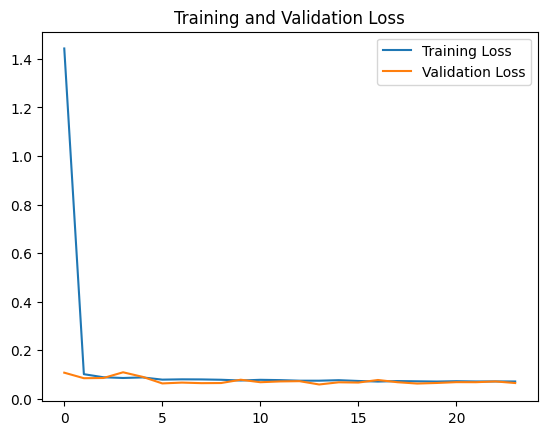

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

In [ ]:
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


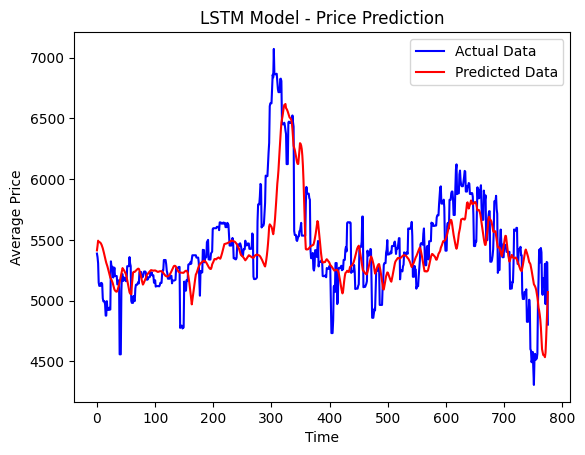

In [ ]:
import matplotlib.pyplot as plt

plt.plot(y_test_rescaled, color='blue', label='Actual Data')
plt.plot(y_pred_rescaled, color='red', label='Predicted Data')
plt.title('LSTM Model - Price Prediction')
plt.xlabel('Time')
plt.ylabel('Average Price')
plt.legend()
plt.show()

In [ ]:
num_features = 1  # 예측할 값이 하나 (평균 가격)

predicted_prices = []

# 현재 데이터를 시계열 입력 형식으로 변환 (현재 마지막 값 이후로 예측을 시작)
current_input = X_test[-1].reshape(1, time_step, num_features)

In [ ]:
# 30일 예측
future_days = 30  # 예측할 기간 설정

for _ in range(future_days):
    # 예측값을 얻음 (모델의 출력값은 (1, 1) 형태)
    next_day_pred = model.predict(current_input)

    # 예측값을 predicted_prices 리스트에 추가
    predicted_prices.append(next_day_pred[0, 0])

    # 예측값을 current_input에 추가하여, 다음 예측에 사용
    # 예측된 값을 current_input의 마지막 값에 추가하고, 가장 첫 값을 버림
    current_input = np.append(current_input[:, 1:, :], next_day_pred.reshape(1, 1, 1), axis=1)

# 예측된 30일 가격 출력
print("Predicted 30 days prices:", predicted_prices)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

In [ ]:
# 1D 배열을 2D 배열로 변환
predicted_prices = np.array(predicted_prices).reshape(-1, 1)
predicted_prices = scaler.inverse_transform(predicted_prices)

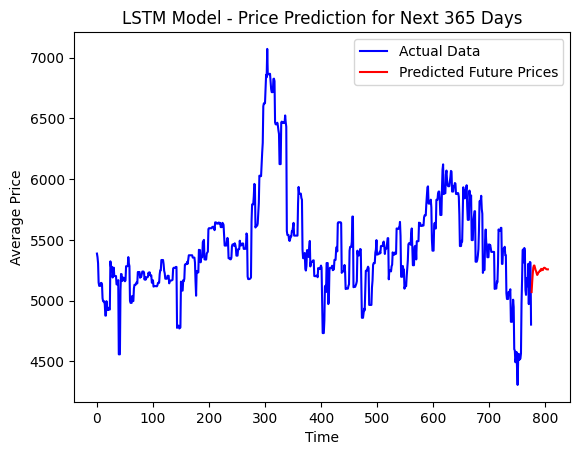

In [ ]:
plt.plot(range(len(y_test_rescaled)), y_test_rescaled, color='blue', label='Actual Data')
plt.plot(range(len(y_test_rescaled), len(y_test_rescaled) + future_days), predicted_prices, color='red', label='Predicted Future Prices')
plt.title('LSTM Model - Price Prediction for Next 365 Days')
plt.xlabel('Time')
plt.ylabel('Average Price')
plt.legend()
plt.show()

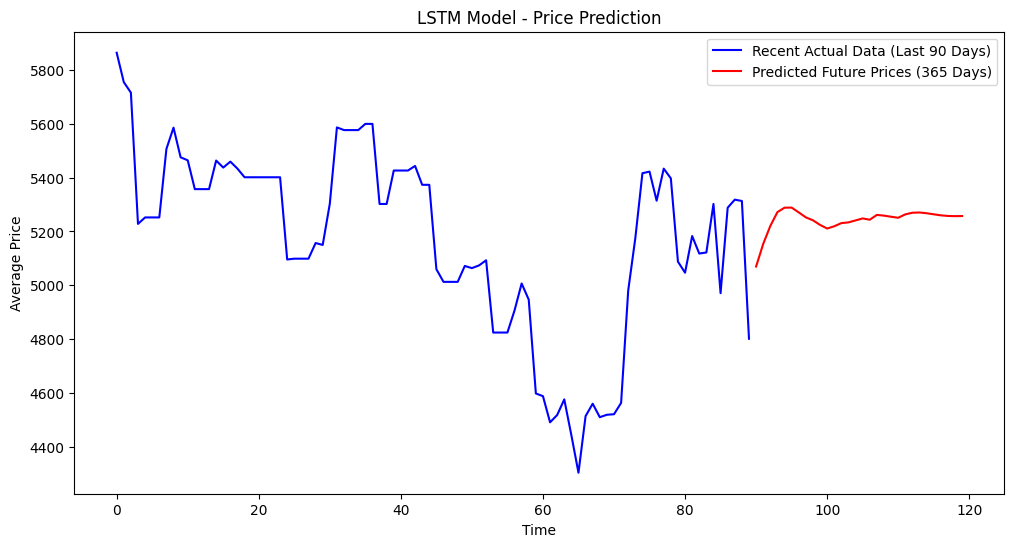

In [ ]:
recent_days = 90
recent_actual_data = y_test_rescaled[-recent_days:]  # 최근 90일 데이터

# x축 범위 생성
x_actual = range(len(recent_actual_data))  # 최근 데이터의 x축
x_predicted = range(len(recent_actual_data), len(recent_actual_data) + future_days)  # 예측 데이터의 x축

# 그래프 생성
plt.figure(figsize=(12, 6))
plt.plot(x_actual, recent_actual_data, color='blue', label='Recent Actual Data (Last 90 Days)')
plt.plot(x_predicted, predicted_prices, color='red', label='Predicted Future Prices (365 Days)')
plt.title('LSTM Model - Price Prediction')
plt.xlabel('Time')
plt.ylabel('Average Price')
plt.legend()
plt.show()

In [ ]:
from datetime import datetime, timedelta

sweetpotato=sweetpotato.reset_index()
sweetpotato['평균'].iloc[-1]
last_date = pd.to_datetime(sweetpotato['구분'].iloc[-1])  # Potato DataFrame에서 마지막 날짜 추출
last_price =sweetpotato['평균'].iloc[-1]  # Potato DataFrame에서 마지막 가격 추출

# 날짜 생성
future_dates = [last_date + timedelta(days=i+1) for i in range(len(predicted_prices))]

# DataFrame 생성

df_0 = pd.DataFrame({
    '날짜': [last_date],
    '예측가격': [last_price]
})
df_future = pd.DataFrame({
    '날짜': future_dates,
    '예측가격': predicted_prices.flatten()  # 배열을 1차원으로 변환
})

df_sweetpotato_extended=pd.concat([df_0, df_future], ignore_index=True)
df_sweetpotato_extended['품목'] = '고구마'

# CSV로 저장
output_path = "sweetpotato_predictions.csv"
df_sweetpotato_extended.to_csv(output_path, index=False, encoding='cp949')


## --------- 깐마늘 LSTM (쉽지않음)------------------

In [ ]:
garlic = pd.read_csv('/content/sample_data/품목_소매가_전부_갱신.csv', encoding='cp949') ### 추가, 변경
garlic = garlic[garlic['품목']=='깐마늘'].drop(columns='품목')  ### 추가, 변경

garlic.head()

,구분,평균,전통시장,유통업체
11937,2014-01-02,6746.0,5630.0,7397.0
11938,2014-01-03,6693.0,5630.0,7313.0
11939,2014-01-04,6693.0,5630.0,7313.0
11940,2014-01-05,6693.0,5630.0,7313.0
11941,2014-01-06,6518.0,5630.0,7036.0


In [ ]:
garlic = garlic.drop(garlic.columns[2:], axis = 1)
garlic.head()

,구분,평균
11937,2014-01-02,6746.0
11938,2014-01-03,6693.0
11939,2014-01-04,6693.0
11940,2014-01-05,6693.0
11941,2014-01-06,6518.0


In [ ]:
garlic['평균'] = garlic['평균'].str.replace(',', '').astype(float)

In [ ]:
garlic['구분'] = pd.to_datetime(garlic['구분'])
garlic.set_index('구분', inplace=True)
garlic = garlic[['평균']]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(garlic)
scaled_data = pd.DataFrame(scaled_data, columns=['평균'], index=garlic.index)

scaled_data

,평균
구분,
2014-01-02,0.114783
2014-01-03,0.108098
2014-01-04,0.108098
2014-01-05,0.108098
2014-01-06,0.086024
...,...
2024-11-29,0.327825
2024-12-02,0.382947
2024-12-03,0.383703


In [ ]:
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size

train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

def create_dataset(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data.iloc[i:i + time_step].values)  # time_step만큼의 데이터를 X로 사용
        y.append(data.iloc[i + time_step].values)  # 그 다음 시점의 데이터를 y로 사용
    return np.array(X), np.array(y)

# 시계열 데이터를 X, y 형식으로 변환
time_step = 10  # 시계열 길이(바꾸는 것)
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [ ]:
# 모델 구성
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

model = Sequential()

# 첫 번째 LSTM 층
model.add(LSTM(200, activation='tanh', return_sequences=True,
               kernel_regularizer=l2(0.01), input_shape=(X_train.shape[1], 1)))
# Dropout
model.add(Dropout(0.2))


# 두 번째 LSTM 층
model.add(LSTM(100, activation='tanh', return_sequences=True,
               kernel_regularizer=l2(0.01)))
# Dropout
model.add(Dropout(0.2))


# 세 번째 LSTM 층
model.add(LSTM(50, activation='tanh', return_sequences=True,
               kernel_regularizer=l2(0.01)))
# Dropout
model.add(Dropout(0.2))


# 네 번째 LSTM 층
model.add(LSTM(50, activation='tanh', return_sequences=True,
               kernel_regularizer=l2(0.01)))
# Dropout
model.add(Dropout(0.2))


# 마지막 LSTM 층
model.add(LSTM(100, activation='tanh', return_sequences=True,
               kernel_regularizer=l2(0.01)))
# Dropout
model.add(Dropout(0.2))

model.add(LSTM(200, activation='tanh', return_sequences=False,
               kernel_regularizer=l2(0.01)))
# Dropout
model.add(Dropout(0.2))


# 출력층 (예측할 값은 하나이므로 유닛 1)
model.add(Dense(1))

# 모델 요약
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_66 (LSTM)                       │ (None, 10, 200)             │         161,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_66 (Dropout)                 │ (None, 10, 200)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_67 (LSTM)                       │ (None, 10, 100)             │         120,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_67 (Dropout)                 │ (None, 10, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_68 (LSTM)                       │ (None, 10, 50)              │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_68 (Dropout)                 │ (None, 10, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_69 (LSTM)                       │ (None, 10, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_69 (Dropout)                 │ (None, 10, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_70 (LSTM)                       │ (None, 10, 100)             │          60,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_70 (Dropout)                 │ (None, 10, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_71 (LSTM)                       │ (None, 200)                 │         240,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_71 (Dropout)                 │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │             201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 633,801 (2.42 MB)

 Trainable params: 633,801 (2.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.0011), loss=rmse, metrics=['mae'])

# EarlyStopping 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size=25, # (바꾸는 것)
                    epochs=100,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

Epoch 1/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 3.8069 - mae: 0.1921 - val_loss: 0.2447 - val_mae: 0.0939
Epoch 2/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.1571 - mae: 0.0563 - val_loss: 0.1200 - val_mae: 0.0685
Epoch 3/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0913 - mae: 0.0461 - val_loss: 0.1287 - val_mae: 0.0895
Epoch 4/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0926 - mae: 0.0526 - val_loss: 0.1093 - val_mae: 0.0686
Epoch 5/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0836 - mae: 0.0478 - val_loss: 0.1213 - val_mae: 0.0869
Epoch 6/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0875 - mae: 0.0527 - val_loss: 0.1098 - val_mae: 0.0752
Epoch 7/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0805 - mae: 0.0473 - val_loss: 0.0971 - val_mae: 0.0629
Epoch 8/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0759 - mae: 0.0449 - val_loss: 0.1037 - val_mae: 0.0728
Epoch 9/100
127/127 ━━━━━━━━━━━━━━━━━━━━

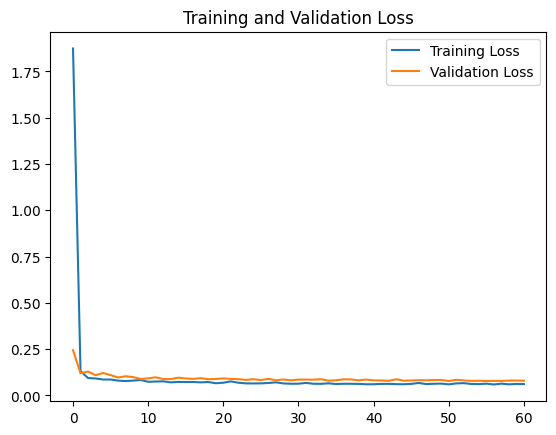

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

In [ ]:
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


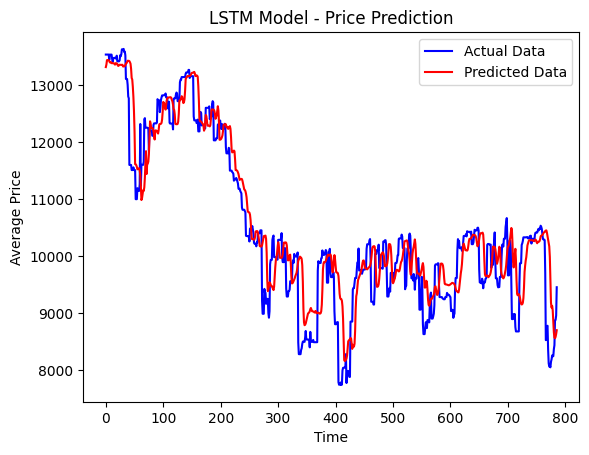

In [ ]:
import matplotlib.pyplot as plt

plt.plot(y_test_rescaled, color='blue', label='Actual Data')
plt.plot(y_pred_rescaled, color='red', label='Predicted Data')
plt.title('LSTM Model - Price Prediction')
plt.xlabel('Time')
plt.ylabel('Average Price')
plt.legend()
plt.show()

In [ ]:
num_features = 1  # 예측할 값이 하나 (평균 가격)

predicted_prices = []

# 현재 데이터를 시계열 입력 형식으로 변환 (현재 마지막 값 이후로 예측을 시작)
current_input = X_test[-1].reshape(1, time_step, num_features)

In [ ]:
# 30일 예측
future_days = 30  # 예측할 기간 설정

for _ in range(future_days):
    # 예측값을 얻음 (모델의 출력값은 (1, 1) 형태)
    next_day_pred = model.predict(current_input)

    # 예측값을 predicted_prices 리스트에 추가
    predicted_prices.append(next_day_pred[0, 0])

    # 예측값을 current_input에 추가하여, 다음 예측에 사용
    # 예측된 값을 current_input의 마지막 값에 추가하고, 가장 첫 값을 버림
    current_input = np.append(current_input[:, 1:, :], next_day_pred.reshape(1, 1, 1), axis=1)

# 예측된 30일 가격 출력
print("Predicted 30 days prices:", predicted_prices)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━

In [ ]:
# 1D 배열을 2D 배열로 변환
predicted_prices = np.array(predicted_prices).reshape(-1, 1)
predicted_prices = scaler.inverse_transform(predicted_prices)

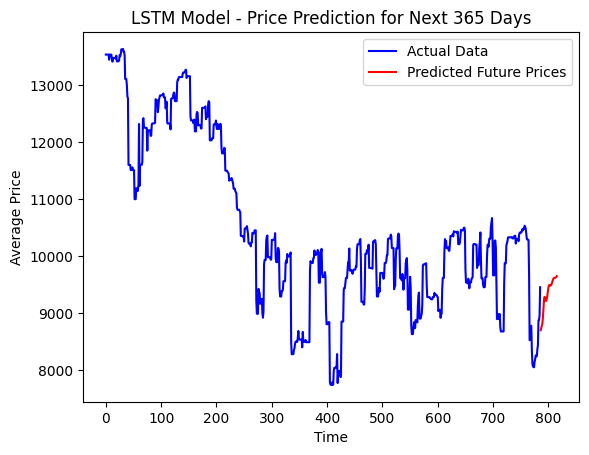

In [ ]:
plt.plot(range(len(y_test_rescaled)), y_test_rescaled, color='blue', label='Actual Data')
plt.plot(range(len(y_test_rescaled), len(y_test_rescaled) + future_days), predicted_prices, color='red', label='Predicted Future Prices')
plt.title('LSTM Model - Price Prediction for Next 365 Days')
plt.xlabel('Time')
plt.ylabel('Average Price')
plt.legend()
plt.show()

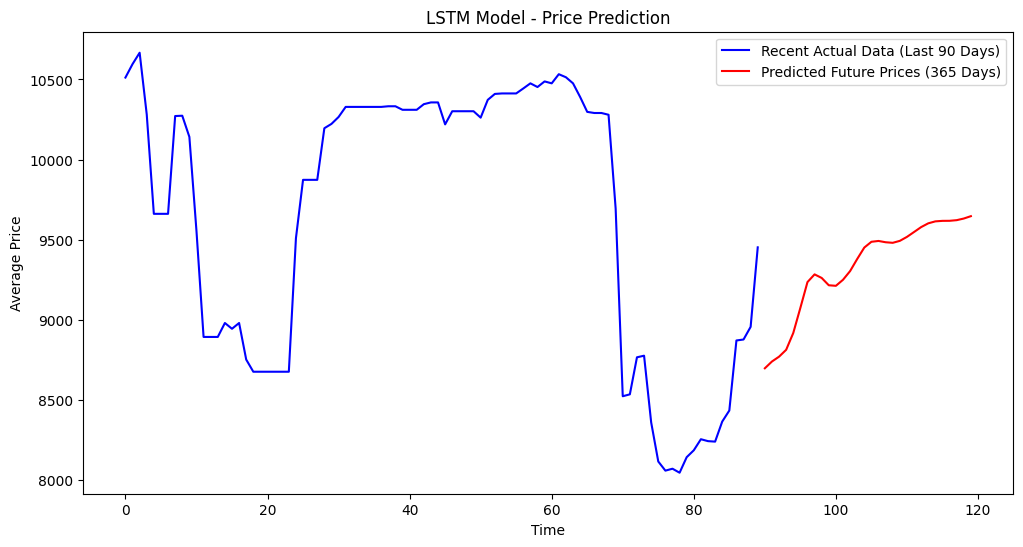

In [ ]:
recent_days = 90
recent_actual_data = y_test_rescaled[-recent_days:]  # 최근 90일 데이터

# x축 범위 생성
x_actual = range(len(recent_actual_data))  # 최근 데이터의 x축
x_predicted = range(len(recent_actual_data), len(recent_actual_data) + future_days)  # 예측 데이터의 x축

# 그래프 생성
plt.figure(figsize=(12, 6))
plt.plot(x_actual, recent_actual_data, color='blue', label='Recent Actual Data (Last 90 Days)')
plt.plot(x_predicted, predicted_prices, color='red', label='Predicted Future Prices (365 Days)')
plt.title('LSTM Model - Price Prediction')
plt.xlabel('Time')
plt.ylabel('Average Price')
plt.legend()
plt.show()

In [ ]:
from datetime import datetime, timedelta

garlic=garlic.reset_index()
garlic['평균'].iloc[-1]
last_date = pd.to_datetime(garlic['구분'].iloc[-1])  # Potato DataFrame에서 마지막 날짜 추출
last_price =garlic['평균'].iloc[-1]  # Potato DataFrame에서 마지막 가격 추출

# 날짜 생성
future_dates = [last_date + timedelta(days=i+1) for i in range(len(predicted_prices))]

# DataFrame 생성

df_0 = pd.DataFrame({
    '날짜': [last_date],
    '예측가격': [last_price]
})
df_future = pd.DataFrame({
    '날짜': future_dates,
    '예측가격': predicted_prices.flatten()  # 배열을 1차원으로 변환
})

df_garlic_extended=pd.concat([df_0, df_future], ignore_index=True)
df_garlic_extended['품목'] = '깐마늘'

# CSV로 저장
output_path = "garlic_predictions.csv"
df_garlic_extended.to_csv(output_path, index=False, encoding='cp949')


## --------- 대파 LSTM ------------------

In [ ]:
springonion = pd.read_csv('/content/sample_data/품목_소매가_전부_갱신.csv', encoding='cp949') ### 추가, 변경
springonion = springonion[springonion['품목']=='대파'].drop(columns='품목')  ### 추가, 변경

springonion.head()

,구분,평균,전통시장,유통업체
19895,2014-01-02,"2,077","1,917","2,166"
19896,2014-01-03,"2,079","1,917","2,170"
19897,2014-01-04,"2,079","1,917","2,170"
19898,2014-01-05,"2,079","1,917","2,170"
19899,2014-01-06,"2,078","1,926","2,163"


In [ ]:
springonion = springonion.drop(springonion.columns[2:], axis = 1)
springonion['평균'] = springonion['평균'].str.replace(',', '').astype(int)
springonion.head()

,구분,평균
19895,2014-01-02,2077
19896,2014-01-03,2079
19897,2014-01-04,2079
19898,2014-01-05,2079
19899,2014-01-06,2078


In [ ]:
springonion['구분'] = pd.to_datetime(springonion['구분'])
springonion.set_index('구분', inplace=True)
springonion = springonion[['평균']]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(springonion)
scaled_data = pd.DataFrame(scaled_data, columns=['평균'], index=springonion.index)

scaled_data

,평균
구분,
2014-01-02,0.072408
2014-01-03,0.072742
2014-01-04,0.072742
2014-01-05,0.072742
2014-01-06,0.072575
...,...
2024-11-29,0.333779
2024-12-02,0.361538
2024-12-03,0.361037


In [ ]:
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size

train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

def create_dataset(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data.iloc[i:i + time_step].values)  # time_step만큼의 데이터를 X로 사용
        y.append(data.iloc[i + time_step].values)  # 그 다음 시점의 데이터를 y로 사용
    return np.array(X), np.array(y)

# 시계열 데이터를 X, y 형식으로 변환
time_step = 28  # 시계열 길이(바꾸는 것)
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [ ]:
# 모델 구성
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

model = Sequential()

# 첫 번째 LSTM 층
model.add(LSTM(200, activation='tanh', return_sequences=True,
               kernel_regularizer=l2(0.01), input_shape=(X_train.shape[1], 1)))
# Dropout
model.add(Dropout(0.2))


# 두 번째 LSTM 층
model.add(LSTM(100, activation='tanh', return_sequences=True,
               kernel_regularizer=l2(0.01)))
# Dropout
model.add(Dropout(0.2))


# 세 번째 LSTM 층
model.add(LSTM(50, activation='tanh', return_sequences=True,
               kernel_regularizer=l2(0.01)))
# Dropout
model.add(Dropout(0.2))


# 네 번째 LSTM 층
model.add(LSTM(50, activation='tanh', return_sequences=True,
               kernel_regularizer=l2(0.01)))
# Dropout
model.add(Dropout(0.2))


# 마지막 LSTM 층
model.add(LSTM(100, activation='tanh', return_sequences=True,
               kernel_regularizer=l2(0.01)))
# Dropout
model.add(Dropout(0.2))

model.add(LSTM(200, activation='tanh', return_sequences=False,
               kernel_regularizer=l2(0.01)))
# Dropout
model.add(Dropout(0.2))


# 출력층 (예측할 값은 하나이므로 유닛 1)
model.add(Dense(1))

# 모델 요약
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_72 (LSTM)                       │ (None, 28, 200)             │         161,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_72 (Dropout)                 │ (None, 28, 200)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_73 (LSTM)                       │ (None, 28, 100)             │         120,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_73 (Dropout)                 │ (None, 28, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_74 (LSTM)                       │ (None, 28, 50)              │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_74 (Dropout)                 │ (None, 28, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_75 (LSTM)                       │ (None, 28, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_75 (Dropout)                 │ (None, 28, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_76 (LSTM)                       │ (None, 28, 100)             │          60,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_76 (Dropout)                 │ (None, 28, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_77 (LSTM)                       │ (None, 200)                 │         240,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_77 (Dropout)                 │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1)                   │             201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 633,801 (2.42 MB)

 Trainable params: 633,801 (2.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.0024), loss=rmse, metrics=['mae'])

# EarlyStopping 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size=50, # (바꾸는 것)
                    epochs=100,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 3.6511 - mae: 0.1214 - val_loss: 0.1353 - val_mae: 0.0515
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1413 - mae: 0.0691 - val_loss: 0.0993 - val_mae: 0.0672
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1036 - mae: 0.0603 - val_loss: 0.0773 - val_mae: 0.0511
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0986 - mae: 0.0580 - val_loss: 0.0801 - val_mae: 0.0551
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.1045 - mae: 0.0640 - val_loss: 0.0848 - val_mae: 0.0588
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.1005 - mae: 0.0620 - val_loss: 0.0788 - val_mae: 0.0555
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0971 - mae: 0.0594 - val_loss: 0.0729 - val_mae: 0.0492
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0925 - mae: 0.0554 - val_loss: 0.0890 - val_mae: 0.0648
Epoch 9/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - lo

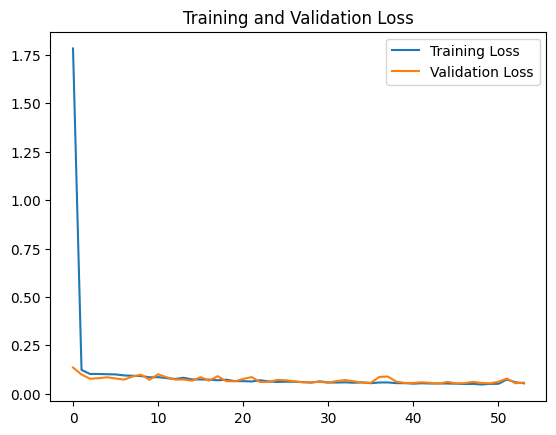

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

In [ ]:
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


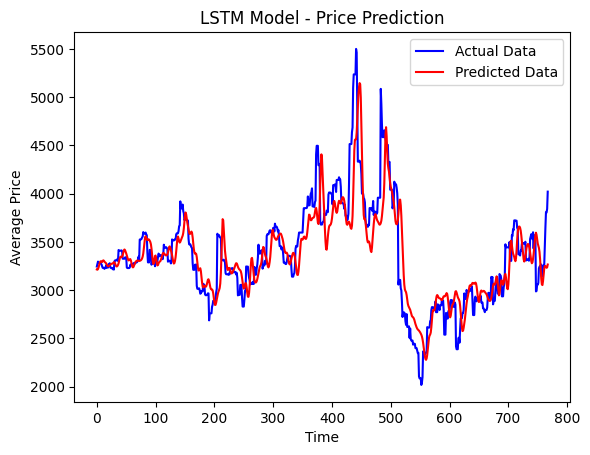

In [ ]:
import matplotlib.pyplot as plt

plt.plot(y_test_rescaled, color='blue', label='Actual Data')
plt.plot(y_pred_rescaled, color='red', label='Predicted Data')
plt.title('LSTM Model - Price Prediction')
plt.xlabel('Time')
plt.ylabel('Average Price')
plt.legend()
plt.show()

In [ ]:
num_features = 1  # 예측할 값이 하나 (평균 가격)

predicted_prices = []

# 현재 데이터를 시계열 입력 형식으로 변환 (현재 마지막 값 이후로 예측을 시작)
current_input = X_test[-1].reshape(1, time_step, num_features)

In [ ]:
# 30일 예측
future_days = 30  # 예측할 기간 설정

for _ in range(future_days):
    # 예측값을 얻음 (모델의 출력값은 (1, 1) 형태)
    next_day_pred = model.predict(current_input)

    # 예측값을 predicted_prices 리스트에 추가
    predicted_prices.append(next_day_pred[0, 0])

    # 예측값을 current_input에 추가하여, 다음 예측에 사용
    # 예측된 값을 current_input의 마지막 값에 추가하고, 가장 첫 값을 버림
    current_input = np.append(current_input[:, 1:, :], next_day_pred.reshape(1, 1, 1), axis=1)

# 예측된 30일 가격 출력
print("Predicted 30 days prices:", predicted_prices)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━

In [ ]:
# 1D 배열을 2D 배열로 변환
predicted_prices = np.array(predicted_prices).reshape(-1, 1)
predicted_prices = scaler.inverse_transform(predicted_prices)

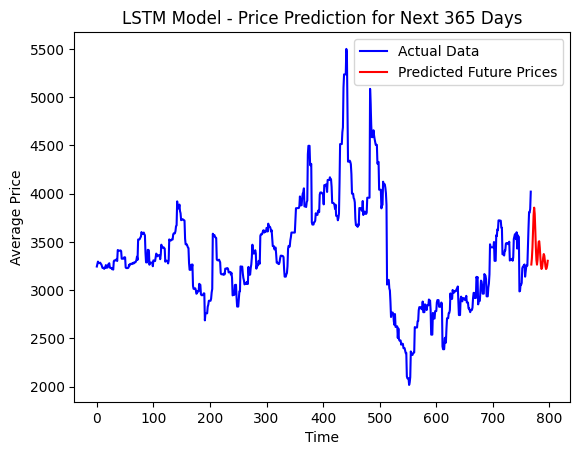

In [ ]:
plt.plot(range(len(y_test_rescaled)), y_test_rescaled, color='blue', label='Actual Data')
plt.plot(range(len(y_test_rescaled), len(y_test_rescaled) + future_days), predicted_prices, color='red', label='Predicted Future Prices')
plt.title('LSTM Model - Price Prediction for Next 365 Days')
plt.xlabel('Time')
plt.ylabel('Average Price')
plt.legend()
plt.show()

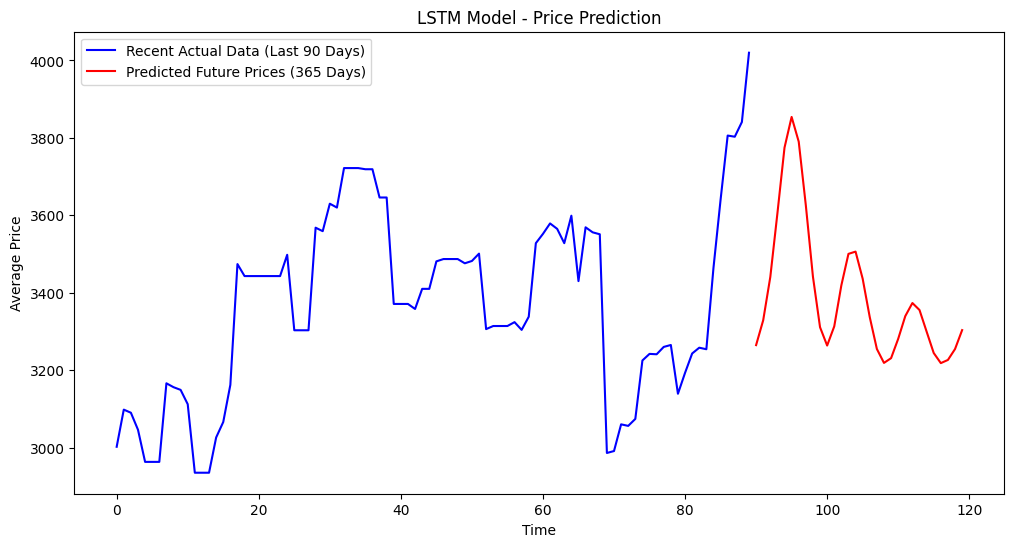

In [ ]:
recent_days = 90
recent_actual_data = y_test_rescaled[-recent_days:]  # 최근 90일 데이터

# x축 범위 생성
x_actual = range(len(recent_actual_data))  # 최근 데이터의 x축
x_predicted = range(len(recent_actual_data), len(recent_actual_data) + future_days)  # 예측 데이터의 x축

# 그래프 생성
plt.figure(figsize=(12, 6))
plt.plot(x_actual, recent_actual_data, color='blue', label='Recent Actual Data (Last 90 Days)')
plt.plot(x_predicted, predicted_prices, color='red', label='Predicted Future Prices (365 Days)')
plt.title('LSTM Model - Price Prediction')
plt.xlabel('Time')
plt.ylabel('Average Price')
plt.legend()
plt.show()

In [ ]:
from datetime import datetime, timedelta

springonion=springonion.reset_index()
springonion['평균'].iloc[-1]
last_date = pd.to_datetime(springonion['구분'].iloc[-1])  # Potato DataFrame에서 마지막 날짜 추출
last_price =springonion['평균'].iloc[-1]  # Potato DataFrame에서 마지막 가격 추출

# 날짜 생성
future_dates = [last_date + timedelta(days=i+1) for i in range(len(predicted_prices))]

# DataFrame 생성

df_0 = pd.DataFrame({
    '날짜': [last_date],
    '예측가격': [last_price]
})
df_future = pd.DataFrame({
    '날짜': future_dates,
    '예측가격': predicted_prices.flatten()  # 배열을 1차원으로 변환
})

df_springonion_extended=pd.concat([df_0, df_future], ignore_index=True)
df_springonion_extended['품목'] = '대파'

# CSV로 저장
output_path = "springonion_predictions.csv"
df_springonion_extended.to_csv(output_path, index=False, encoding='cp949')


## --------- 시금치 LSTM ------------------

In [ ]:
spanich = pd.read_csv('/content/sample_data/품목_소매가_전부_갱신.csv', encoding='cp949') ### 추가, 변경
spanich = spanich[spanich['품목']=='시금치'].drop(columns='품목')  ### 추가, 변경

spanich.head()

,구분,평균,전통시장,유통업체
31832,2014-01-02,354,316,394
31833,2014-01-03,349,314,387
31834,2014-01-04,349,314,387
31835,2014-01-05,349,314,387
31836,2014-01-06,348,314,385


In [ ]:
spanich = spanich.drop(spanich.columns[2:], axis = 1)
spanich.head()

,구분,평균
31832,2014-01-02,354
31833,2014-01-03,349
31834,2014-01-04,349
31835,2014-01-05,349
31836,2014-01-06,348


In [ ]:
spanich['평균'] = spanich['평균'].str.replace(',', '').astype(int)

In [ ]:
spanich['구분'] = pd.to_datetime(spanich['구분'])
spanich.set_index('구분', inplace=True)
spanich = spanich[['평균']]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(spanich)
scaled_data = pd.DataFrame(scaled_data, columns=['평균'], index=spanich.index)

scaled_data

,평균
구분,
2014-01-02,0.022597
2014-01-03,0.021356
2014-01-04,0.021356
2014-01-05,0.021356
2014-01-06,0.021108
...,...
2024-11-29,0.165880
2024-12-02,0.174820
2024-12-03,0.172585


In [ ]:
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size

train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

def create_dataset(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data.iloc[i:i + time_step].values)  # time_step만큼의 데이터를 X로 사용
        y.append(data.iloc[i + time_step].values)  # 그 다음 시점의 데이터를 y로 사용
    return np.array(X), np.array(y)

# 시계열 데이터를 X, y 형식으로 변환
time_step = 18  # 시계열 길이(바꾸는 것)
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [ ]:
# 모델 구성
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

model = Sequential()

# 첫 번째 LSTM 층
model.add(LSTM(200, activation='tanh', return_sequences=True,
               kernel_regularizer=l2(0.01), input_shape=(X_train.shape[1], 1)))
# Dropout
model.add(Dropout(0.2))


# 두 번째 LSTM 층
model.add(LSTM(100, activation='tanh', return_sequences=True,
               kernel_regularizer=l2(0.01)))
# Dropout
model.add(Dropout(0.2))


# 세 번째 LSTM 층
model.add(LSTM(50, activation='tanh', return_sequences=True,
               kernel_regularizer=l2(0.01)))
# Dropout
model.add(Dropout(0.2))


# 네 번째 LSTM 층
model.add(LSTM(50, activation='tanh', return_sequences=True,
               kernel_regularizer=l2(0.01)))
# Dropout
model.add(Dropout(0.2))


# 마지막 LSTM 층
model.add(LSTM(100, activation='tanh', return_sequences=True,
               kernel_regularizer=l2(0.01)))
# Dropout
model.add(Dropout(0.2))

model.add(LSTM(200, activation='tanh', return_sequences=False,
               kernel_regularizer=l2(0.01)))
# Dropout
model.add(Dropout(0.2))


# 출력층 (예측할 값은 하나이므로 유닛 1)
model.add(Dense(1))

# 모델 요약
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_78 (LSTM)                       │ (None, 18, 200)             │         161,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_78 (Dropout)                 │ (None, 18, 200)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_79 (LSTM)                       │ (None, 18, 100)             │         120,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_79 (Dropout)                 │ (None, 18, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_80 (LSTM)                       │ (None, 18, 50)              │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_80 (Dropout)                 │ (None, 18, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_81 (LSTM)                       │ (None, 18, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_81 (Dropout)                 │ (None, 18, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_82 (LSTM)                       │ (None, 18, 100)             │          60,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_82 (Dropout)                 │ (None, 18, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_83 (LSTM)                       │ (None, 200)                 │         240,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_83 (Dropout)                 │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │             201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 633,801 (2.42 MB)

 Trainable params: 633,801 (2.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.002), loss=rmse, metrics=['mae'])

# EarlyStopping 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size=25, # (바꾸는 것)
                    epochs=100,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

Epoch 1/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 2.6029 - mae: 0.0643 - val_loss: 0.1883 - val_mae: 0.1644
Epoch 2/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.1130 - mae: 0.0627 - val_loss: 0.1294 - val_mae: 0.1098
Epoch 3/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.1003 - mae: 0.0571 - val_loss: 0.1150 - val_mae: 0.0962
Epoch 4/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0952 - mae: 0.0516 - val_loss: 0.1181 - val_mae: 0.1031
Epoch 5/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0943 - mae: 0.0545 - val_loss: 0.1306 - val_mae: 0.1132
Epoch 6/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0921 - mae: 0.0499 - val_loss: 0.1140 - val_mae: 0.0970
Epoch 7/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0936 - mae: 0.0512 - val_loss: 0.1552 - val_mae: 0.1368
Epoch 8/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0964 - mae: 0.0541 - val_loss: 0.1427 - val_mae: 0.1246
Epoch 9/100
127/127 ━━━━━━━━━━━━━━━━━━━━

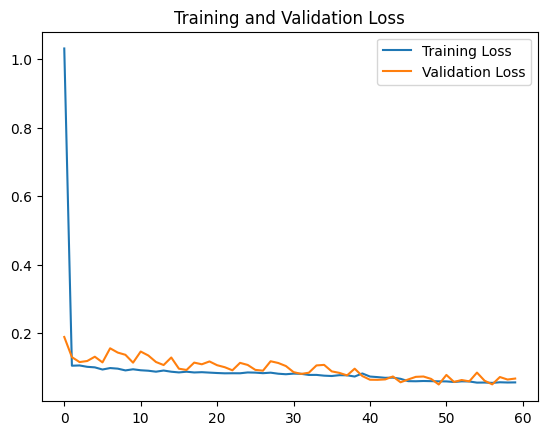

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

In [ ]:
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


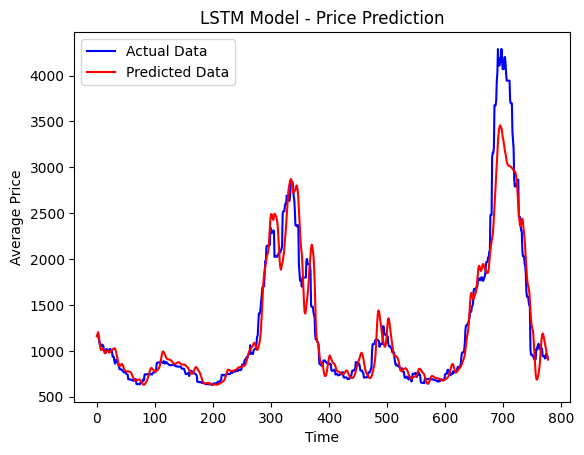

In [ ]:
import matplotlib.pyplot as plt

plt.plot(y_test_rescaled, color='blue', label='Actual Data')
plt.plot(y_pred_rescaled, color='red', label='Predicted Data')
plt.title('LSTM Model - Price Prediction')
plt.xlabel('Time')
plt.ylabel('Average Price')
plt.legend()
plt.show()

In [ ]:
num_features = 1  # 예측할 값이 하나 (평균 가격)

predicted_prices = []

# 현재 데이터를 시계열 입력 형식으로 변환 (현재 마지막 값 이후로 예측을 시작)
current_input = X_test[-1].reshape(1, time_step, num_features)

In [ ]:
# 30일 예측
future_days = 30  # 예측할 기간 설정

for _ in range(future_days):
    # 예측값을 얻음 (모델의 출력값은 (1, 1) 형태)
    next_day_pred = model.predict(current_input)

    # 예측값을 predicted_prices 리스트에 추가
    predicted_prices.append(next_day_pred[0, 0])

    # 예측값을 current_input에 추가하여, 다음 예측에 사용
    # 예측된 값을 current_input의 마지막 값에 추가하고, 가장 첫 값을 버림
    current_input = np.append(current_input[:, 1:, :], next_day_pred.reshape(1, 1, 1), axis=1)

# 예측된 30일 가격 출력
print("Predicted 30 days prices:", predicted_prices)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

In [ ]:
# 1D 배열을 2D 배열로 변환
predicted_prices = np.array(predicted_prices).reshape(-1, 1)
predicted_prices = scaler.inverse_transform(predicted_prices)

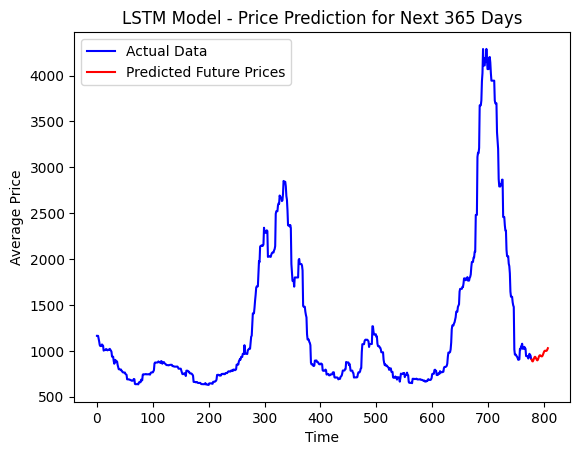

In [ ]:
plt.plot(range(len(y_test_rescaled)), y_test_rescaled, color='blue', label='Actual Data')
plt.plot(range(len(y_test_rescaled), len(y_test_rescaled) + future_days), predicted_prices, color='red', label='Predicted Future Prices')
plt.title('LSTM Model - Price Prediction for Next 365 Days')
plt.xlabel('Time')
plt.ylabel('Average Price')
plt.legend()
plt.show()

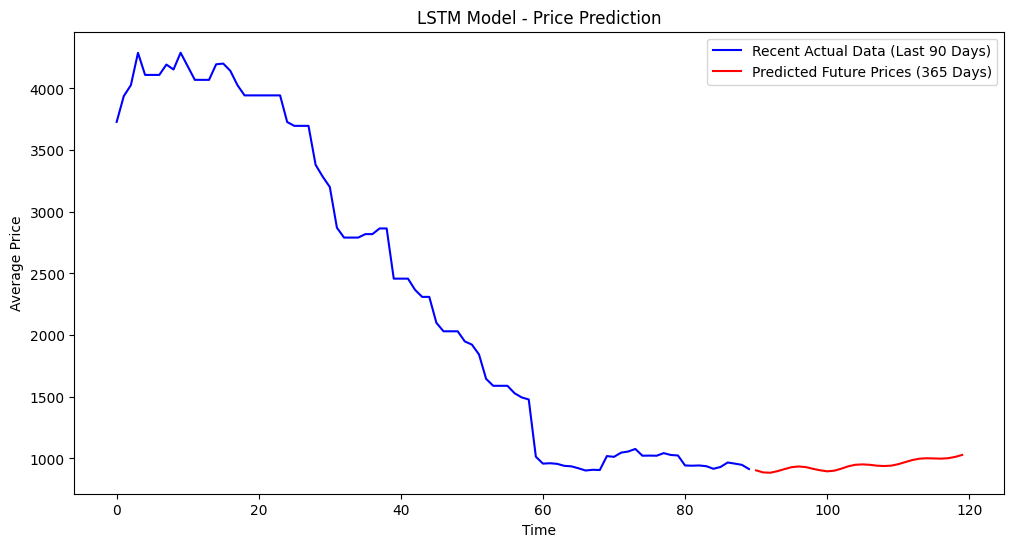

In [ ]:
recent_days = 90
recent_actual_data = y_test_rescaled[-recent_days:]  # 최근 90일 데이터

# x축 범위 생성
x_actual = range(len(recent_actual_data))  # 최근 데이터의 x축
x_predicted = range(len(recent_actual_data), len(recent_actual_data) + future_days)  # 예측 데이터의 x축

# 그래프 생성
plt.figure(figsize=(12, 6))
plt.plot(x_actual, recent_actual_data, color='blue', label='Recent Actual Data (Last 90 Days)')
plt.plot(x_predicted, predicted_prices, color='red', label='Predicted Future Prices (365 Days)')
plt.title('LSTM Model - Price Prediction')
plt.xlabel('Time')
plt.ylabel('Average Price')
plt.legend()
plt.show()

In [ ]:
from datetime import datetime, timedelta

spanich=spanich.reset_index()
spanich['평균'].iloc[-1]
last_date = pd.to_datetime(spanich['구분'].iloc[-1])  # Potato DataFrame에서 마지막 날짜 추출
last_price =spanich['평균'].iloc[-1]  # Potato DataFrame에서 마지막 가격 추출

# 날짜 생성
future_dates = [last_date + timedelta(days=i+1) for i in range(len(predicted_prices))]

# DataFrame 생성

df_0 = pd.DataFrame({
    '날짜': [last_date],
    '예측가격': [last_price]
})
df_future = pd.DataFrame({
    '날짜': future_dates,
    '예측가격': predicted_prices.flatten()  # 배열을 1차원으로 변환
})

df_spanich_extended=pd.concat([df_0, df_future], ignore_index=True)
df_spanich_extended['품목'] = '시금치'

# CSV로 저장
output_path = "spanich_predictions.csv"
df_spanich_extended.to_csv(output_path, index=False, encoding='cp949')


## --------- 쌀 LSTM ------------------

In [ ]:
rice = pd.read_csv('/content/sample_data/품목_소매가_전부_갱신.csv', encoding='cp949') ### 추가, 변경
rice = rice[rice['품목']=='쌀'].drop(columns='품목')  ### 추가, 변경

rice.head()

,구분,평균,전통시장,유통업체
35811,2014-01-02,"46,082","47,907","45,060"
35812,2014-01-03,"45,964","47,907","44,876"
35813,2014-01-04,"45,964","47,907","44,876"
35814,2014-01-05,"45,964","47,907","44,876"
35815,2014-01-06,"45,964","47,907","44,876"


In [ ]:
rice = rice.drop(rice.columns[2:], axis = 1)
rice['평균'] = rice['평균'].str.replace(',', '').astype(int)
rice.head()

,구분,평균
35811,2014-01-02,46082
35812,2014-01-03,45964
35813,2014-01-04,45964
35814,2014-01-05,45964
35815,2014-01-06,45964


In [ ]:
rice['구분'] = pd.to_datetime(rice['구분'])
rice.set_index('구분', inplace=True)
rice = rice[['평균']]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(rice)
scaled_data = pd.DataFrame(scaled_data, columns=['평균'], index=rice.index)

scaled_data

,평균
구분,
2014-01-02,0.435692
2014-01-03,0.431515
2014-01-04,0.431515
2014-01-05,0.431515
2014-01-06,0.431515
...,...
2024-11-29,0.735476
2024-12-02,0.742911
2024-12-03,0.739229


In [ ]:
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size

train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

def create_dataset(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data.iloc[i:i + time_step].values)  # time_step만큼의 데이터를 X로 사용
        y.append(data.iloc[i + time_step].values)  # 그 다음 시점의 데이터를 y로 사용
    return np.array(X), np.array(y)

# 시계열 데이터를 X, y 형식으로 변환
time_step = 20  # 시계열 길이(바꾸는 것)
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [ ]:
# 모델 구성
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

model = Sequential()

# 첫 번째 LSTM 층
model.add(LSTM(200, activation='tanh', return_sequences=True,
               kernel_regularizer=l2(0.01), input_shape=(X_train.shape[1], 1)))
# Dropout
model.add(Dropout(0.2))


# 두 번째 LSTM 층
model.add(LSTM(100, activation='tanh', return_sequences=True,
               kernel_regularizer=l2(0.01)))
# Dropout
model.add(Dropout(0.2))


# 세 번째 LSTM 층
model.add(LSTM(50, activation='tanh', return_sequences=True,
               kernel_regularizer=l2(0.01)))
# Dropout
model.add(Dropout(0.2))


# 네 번째 LSTM 층
model.add(LSTM(50, activation='tanh', return_sequences=True,
               kernel_regularizer=l2(0.01)))
# Dropout
model.add(Dropout(0.2))


# 마지막 LSTM 층
model.add(LSTM(100, activation='tanh', return_sequences=True,
               kernel_regularizer=l2(0.01)))
# Dropout
model.add(Dropout(0.2))

model.add(LSTM(200, activation='tanh', return_sequences=False,
               kernel_regularizer=l2(0.01)))
# Dropout
model.add(Dropout(0.2))


# 출력층 (예측할 값은 하나이므로 유닛 1)
model.add(Dense(1))

# 모델 요약
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_84 (LSTM)                       │ (None, 20, 200)             │         161,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_84 (Dropout)                 │ (None, 20, 200)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_85 (LSTM)                       │ (None, 20, 100)             │         120,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_85 (Dropout)                 │ (None, 20, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_86 (LSTM)                       │ (None, 20, 50)              │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_86 (Dropout)                 │ (None, 20, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_87 (LSTM)                       │ (None, 20, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_87 (Dropout)                 │ (None, 20, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_88 (LSTM)                       │ (None, 20, 100)             │          60,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_88 (Dropout)                 │ (None, 20, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_89 (LSTM)                       │ (None, 200)                 │         240,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_89 (Dropout)                 │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │             201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 633,801 (2.42 MB)

 Trainable params: 633,801 (2.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.0019), loss=rmse, metrics=['mae'])

# EarlyStopping 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size=50, # (바꾸는 것)
                    epochs=100,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 4.1592 - mae: 0.1732 - val_loss: 0.3382 - val_mae: 0.0467
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.2626 - mae: 0.0530 - val_loss: 0.1395 - val_mae: 0.0523
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.1230 - mae: 0.0445 - val_loss: 0.0894 - val_mae: 0.0368
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0896 - mae: 0.0383 - val_loss: 0.0752 - val_mae: 0.0376
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0919 - mae: 0.0518 - val_loss: 0.0912 - val_mae: 0.0596
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0795 - mae: 0.0441 - val_loss: 0.0718 - val_mae: 0.0420
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0677 - mae: 0.0371 - val_loss: 0.0703 - val_mae: 0.0429
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0673 - mae: 0.0383 - val_loss: 0.0730 - val_mae: 0.0464
Epoch 9/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - lo

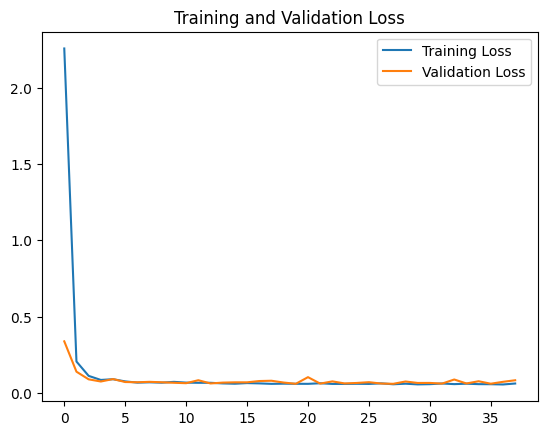

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

In [ ]:
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


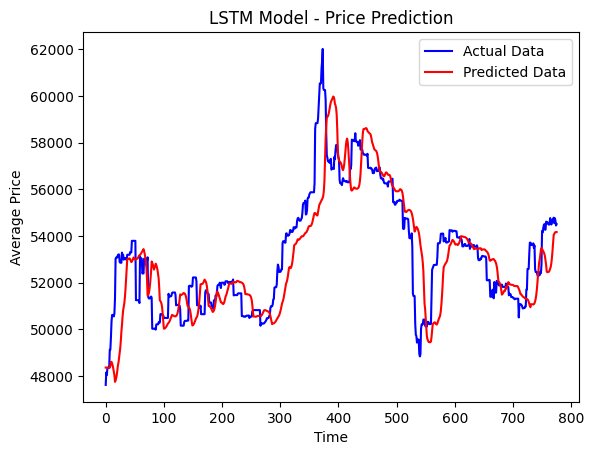

In [ ]:
import matplotlib.pyplot as plt

plt.plot(y_test_rescaled, color='blue', label='Actual Data')
plt.plot(y_pred_rescaled, color='red', label='Predicted Data')
plt.title('LSTM Model - Price Prediction')
plt.xlabel('Time')
plt.ylabel('Average Price')
plt.legend()
plt.show()

In [ ]:
num_features = 1  # 예측할 값이 하나 (평균 가격)

predicted_prices = []

# 현재 데이터를 시계열 입력 형식으로 변환 (현재 마지막 값 이후로 예측을 시작)
current_input = X_test[-1].reshape(1, time_step, num_features)

In [ ]:
# 30일 예측
future_days = 30  # 예측할 기간 설정

for _ in range(future_days):
    # 예측값을 얻음 (모델의 출력값은 (1, 1) 형태)
    next_day_pred = model.predict(current_input)

    # 예측값을 predicted_prices 리스트에 추가
    predicted_prices.append(next_day_pred[0, 0])

    # 예측값을 current_input에 추가하여, 다음 예측에 사용
    # 예측된 값을 current_input의 마지막 값에 추가하고, 가장 첫 값을 버림
    current_input = np.append(current_input[:, 1:, :], next_day_pred.reshape(1, 1, 1), axis=1)

# 예측된 30일 가격 출력
print("Predicted 30 days prices:", predicted_prices)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

In [ ]:
# 1D 배열을 2D 배열로 변환
predicted_prices = np.array(predicted_prices).reshape(-1, 1)
predicted_prices = scaler.inverse_transform(predicted_prices)

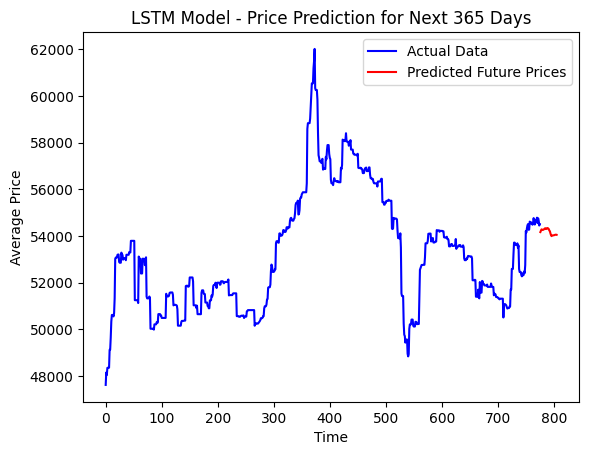

In [ ]:
plt.plot(range(len(y_test_rescaled)), y_test_rescaled, color='blue', label='Actual Data')
plt.plot(range(len(y_test_rescaled), len(y_test_rescaled) + future_days), predicted_prices, color='red', label='Predicted Future Prices')
plt.title('LSTM Model - Price Prediction for Next 365 Days')
plt.xlabel('Time')
plt.ylabel('Average Price')
plt.legend()
plt.show()

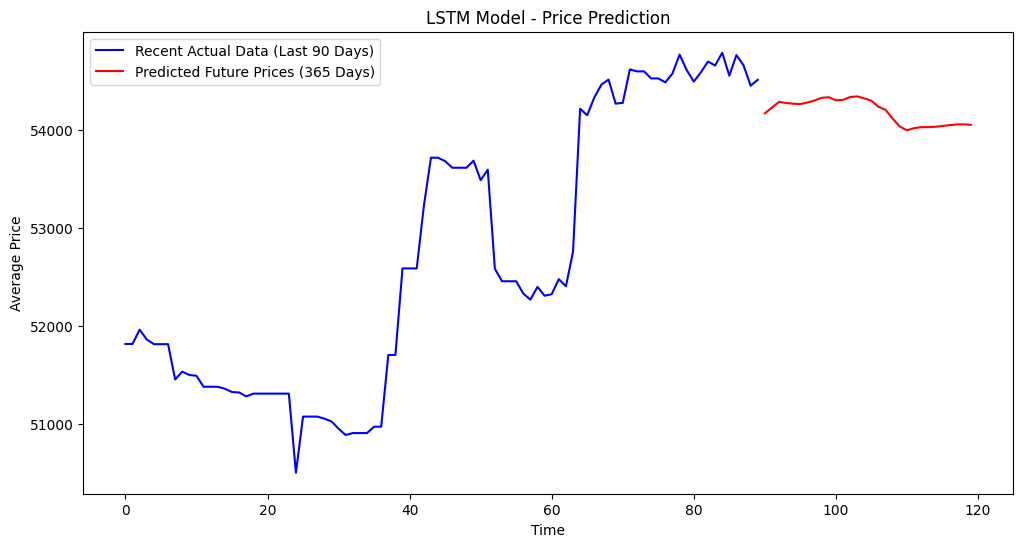

In [ ]:
recent_days = 90
recent_actual_data = y_test_rescaled[-recent_days:]  # 최근 90일 데이터

# x축 범위 생성
x_actual = range(len(recent_actual_data))  # 최근 데이터의 x축
x_predicted = range(len(recent_actual_data), len(recent_actual_data) + future_days)  # 예측 데이터의 x축

# 그래프 생성
plt.figure(figsize=(12, 6))
plt.plot(x_actual, recent_actual_data, color='blue', label='Recent Actual Data (Last 90 Days)')
plt.plot(x_predicted, predicted_prices, color='red', label='Predicted Future Prices (365 Days)')
plt.title('LSTM Model - Price Prediction')
plt.xlabel('Time')
plt.ylabel('Average Price')
plt.legend()
plt.show()

In [ ]:
from datetime import datetime, timedelta

rice=rice.reset_index()
rice['평균'].iloc[-1]
last_date = pd.to_datetime(rice['구분'].iloc[-1])  # Potato DataFrame에서 마지막 날짜 추출
last_price =rice['평균'].iloc[-1]  # Potato DataFrame에서 마지막 가격 추출

# 날짜 생성
future_dates = [last_date + timedelta(days=i+1) for i in range(len(predicted_prices))]

# DataFrame 생성

df_0 = pd.DataFrame({
    '날짜': [last_date],
    '예측가격': [last_price]
})
df_future = pd.DataFrame({
    '날짜': future_dates,
    '예측가격': predicted_prices.flatten()  # 배열을 1차원으로 변환
})

df_rice_extended=pd.concat([df_0, df_future], ignore_index=True)
df_rice_extended['품목'] = '쌀'

# CSV로 저장
output_path = "rice_predictions.csv"
df_rice_extended.to_csv(output_path, index=False, encoding='cp949')


## --------- 양배추 LSTM ------------------

In [ ]:
cabbage = pd.read_csv('/content/sample_data/품목_소매가_전부_갱신.csv', encoding='cp949') ### 추가, 변경
cabbage = cabbage[cabbage['품목']=='감자'].drop(columns='품목')  ### 추가, 변경

potato.head()

In [ ]:
potato = potato.drop(potato.columns[2:], axis = 1)
potato.head()

In [ ]:
potato['구분'] = pd.to_datetime(potato['구분'])
potato.set_index('구분', inplace=True)
potato = potato[['평균']]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(potato)
scaled_data = pd.DataFrame(scaled_data, columns=['평균'], index=potato.index)

scaled_data

In [ ]:
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size

train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

def create_dataset(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data.iloc[i:i + time_step].values)  # time_step만큼의 데이터를 X로 사용
        y.append(data.iloc[i + time_step].values)  # 그 다음 시점의 데이터를 y로 사용
    return np.array(X), np.array(y)

# 시계열 데이터를 X, y 형식으로 변환
time_step = 20  # 시계열 길이(바꾸는 것)
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [ ]:
# 모델 구성
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

model = Sequential()

# 첫 번째 LSTM 층
model.add(LSTM(100, activation='tanh', return_sequences=True,
               kernel_regularizer=l2(0.01), input_shape=(X_train.shape[1], 1)))
# Dropout
model.add(Dropout(0.2))


# 두 번째 LSTM 층
model.add(LSTM(100, activation='tanh', return_sequences=True,
               kernel_regularizer=l2(0.01)))
# Dropout
model.add(Dropout(0.2))


# 세 번째 LSTM 층
model.add(LSTM(50, activation='tanh', return_sequences=True,
               kernel_regularizer=l2(0.01)))
# Dropout
model.add(Dropout(0.2))


# 네 번째 LSTM 층
model.add(LSTM(50, activation='tanh', return_sequences=True,
               kernel_regularizer=l2(0.01)))
# Dropout
model.add(Dropout(0.2))


# 마지막 LSTM 층
model.add(LSTM(100, activation='tanh', return_sequences=True,
               kernel_regularizer=l2(0.01)))
# Dropout
model.add(Dropout(0.2))

model.add(LSTM(200, activation='tanh', return_sequences=False,
               kernel_regularizer=l2(0.01)))
# Dropout
model.add(Dropout(0.2))


# 출력층 (예측할 값은 하나이므로 유닛 1)
model.add(Dense(1))

# 모델 요약
model.summary()

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.0028), loss=rmse, metrics=['mae'])

# EarlyStopping 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size=50, # (바꾸는 것)
                    epochs=100,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

In [ ]:
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(y_test_rescaled, color='blue', label='Actual Data')
plt.plot(y_pred_rescaled, color='red', label='Predicted Data')
plt.title('LSTM Model - Price Prediction')
plt.xlabel('Time')
plt.ylabel('Average Price')
plt.legend()
plt.show()

In [ ]:
num_features = 1  # 예측할 값이 하나 (평균 가격)

predicted_prices = []

# 현재 데이터를 시계열 입력 형식으로 변환 (현재 마지막 값 이후로 예측을 시작)
current_input = X_test[-1].reshape(1, time_step, num_features)

In [ ]:
# 30일 예측
future_days = 30  # 예측할 기간 설정

for _ in range(future_days):
    # 예측값을 얻음 (모델의 출력값은 (1, 1) 형태)
    next_day_pred = model.predict(current_input)

    # 예측값을 predicted_prices 리스트에 추가
    predicted_prices.append(next_day_pred[0, 0])

    # 예측값을 current_input에 추가하여, 다음 예측에 사용
    # 예측된 값을 current_input의 마지막 값에 추가하고, 가장 첫 값을 버림
    current_input = np.append(current_input[:, 1:, :], next_day_pred.reshape(1, 1, 1), axis=1)

# 예측된 30일 가격 출력
print("Predicted 30 days prices:", predicted_prices)

In [ ]:
# 1D 배열을 2D 배열로 변환
predicted_prices = np.array(predicted_prices).reshape(-1, 1)
predicted_prices = scaler.inverse_transform(predicted_prices)

In [ ]:
plt.plot(range(len(y_test_rescaled)), y_test_rescaled, color='blue', label='Actual Data')
plt.plot(range(len(y_test_rescaled), len(y_test_rescaled) + future_days), predicted_prices, color='red', label='Predicted Future Prices')
plt.title('LSTM Model - Price Prediction for Next 365 Days')
plt.xlabel('Time')
plt.ylabel('Average Price')
plt.legend()
plt.show()

In [ ]:
recent_days = 90
recent_actual_data = y_test_rescaled[-recent_days:]  # 최근 90일 데이터

# x축 범위 생성
x_actual = range(len(recent_actual_data))  # 최근 데이터의 x축
x_predicted = range(len(recent_actual_data), len(recent_actual_data) + future_days)  # 예측 데이터의 x축

# 그래프 생성
plt.figure(figsize=(12, 6))
plt.plot(x_actual, recent_actual_data, color='blue', label='Recent Actual Data (Last 90 Days)')
plt.plot(x_predicted, predicted_prices, color='red', label='Predicted Future Prices (365 Days)')
plt.title('LSTM Model - Price Prediction')
plt.xlabel('Time')
plt.ylabel('Average Price')
plt.legend()
plt.show()

In [ ]:
from datetime import datetime, timedelta

rice=rice.reset_index()
rice['평균'].iloc[-1]
last_date = pd.to_datetime(rice['구분'].iloc[-1])  # Potato DataFrame에서 마지막 날짜 추출
last_price =rice['평균'].iloc[-1]  # Potato DataFrame에서 마지막 가격 추출

# 날짜 생성
future_dates = [last_date + timedelta(days=i+1) for i in range(len(predicted_prices))]

# DataFrame 생성

df_0 = pd.DataFrame({
    '날짜': [last_date],
    '예측가격': [last_price]
})
df_future = pd.DataFrame({
    '날짜': future_dates,
    '예측가격': predicted_prices.flatten()  # 배열을 1차원으로 변환
})

df_rice_extended=pd.concat([df_0, df_future], ignore_index=True)
df_rice_extended['품목'] = '양배추'

# CSV로 저장
output_path = "rice_predictions.csv"
df_rice_extended.to_csv(output_path, index=False, encoding='cp949')


## --------- 양파 LSTM ------------------

In [36]:
onion = pd.read_csv('/content/sample_data/품목_소매가_전부_갱신.csv', encoding='cp949') ### 추가, 변경
onion = onion[onion['품목']=='양파'].drop(columns='품목')  ### 추가, 변경

onion.head()

,구분,평균,전통시장,유통업체
47748,2014-01-02,"1,779","1,617","1,869"
47749,2014-01-03,"1,759","1,617","1,839"
47750,2014-01-04,"1,759","1,617","1,839"
47751,2014-01-05,"1,759","1,617","1,839"
47752,2014-01-06,"1,746","1,617","1,818"


In [37]:
onion = onion.drop(onion.columns[2:], axis = 1)
onion['평균'] = onion['평균'].str.replace(',', '').astype(float)
onion.head()

,구분,평균
47748,2014-01-02,1779.0
47749,2014-01-03,1759.0
47750,2014-01-04,1759.0
47751,2014-01-05,1759.0
47752,2014-01-06,1746.0


In [38]:
onion['구분'] = pd.to_datetime(onion['구분'])

onion.set_index('구분', inplace=True)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(onion)

scaled_data = pd.DataFrame(scaled_data, columns=['평균'], index=onion.index)

scaled_data

,평균
구분,
2014-01-02,0.248442
2014-01-03,0.240133
2014-01-04,0.240133
2014-01-05,0.240133
2014-01-06,0.234732
...,...
2024-11-29,0.293727
2024-12-02,0.329871
2024-12-03,0.344412


In [39]:
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size

train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

def create_dataset(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data.iloc[i:i + time_step].values)  # time_step만큼의 데이터를 X로 사용
        y.append(data.iloc[i + time_step].values)  # 그 다음 시점의 데이터를 y로 사용
    return np.array(X), np.array(y)

# 시계열 데이터를 X, y 형식으로 변환
time_step = 21  # 시계열 길이(바꾸는 것)
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [40]:
# 모델 구성
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

model = Sequential()

# 첫 번째 LSTM 층
model.add(LSTM(200, activation='tanh', return_sequences=True,
               kernel_regularizer=l2(0.01), input_shape=(X_train.shape[1], 1)))
# Dropout
model.add(Dropout(0.2))


# 두 번째 LSTM 층
model.add(LSTM(100, activation='tanh', return_sequences=True,
               kernel_regularizer=l2(0.01)))
# Dropout
model.add(Dropout(0.2))


# 세 번째 LSTM 층
model.add(LSTM(50, activation='tanh', return_sequences=True,
               kernel_regularizer=l2(0.01)))
# Dropout
model.add(Dropout(0.2))


# 네 번째 LSTM 층
model.add(LSTM(50, activation='tanh', return_sequences=True,
               kernel_regularizer=l2(0.01)))
# Dropout
model.add(Dropout(0.2))


# 마지막 LSTM 층
model.add(LSTM(100, activation='tanh', return_sequences=True,
               kernel_regularizer=l2(0.01)))
# Dropout
model.add(Dropout(0.2))

model.add(LSTM(200, activation='tanh', return_sequences=False,
               kernel_regularizer=l2(0.01)))
# Dropout
model.add(Dropout(0.2))


# 출력층 (예측할 값은 하나이므로 유닛 1)
model.add(Dense(1))

# 모델 요약
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                       │ (None, 21, 200)             │         161,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 21, 200)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 21, 100)             │         120,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 21, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_14 (LSTM)                       │ (None, 21, 50)              │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 21, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_15 (LSTM)                       │ (None, 21, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 21, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_16 (LSTM)                       │ (None, 21, 100)             │          60,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 21, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_17 (LSTM)                       │ (None, 200)                 │         240,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 633,801 (2.42 MB)

 Trainable params: 633,801 (2.42 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.0013), loss=rmse, metrics=['mae'])

# EarlyStopping 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [42]:
history = model.fit(X_train, y_train,
                    batch_size=25, # (바꾸는 것)
                    epochs=100,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

Epoch 1/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 3.4745 - mae: 0.0997 - val_loss: 0.2082 - val_mae: 0.1018
Epoch 2/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.1398 - mae: 0.0568 - val_loss: 0.1070 - val_mae: 0.0689
Epoch 3/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.1021 - mae: 0.0571 - val_loss: 0.0874 - val_mae: 0.0616
Epoch 4/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0965 - mae: 0.0579 - val_loss: 0.0854 - val_mae: 0.0589
Epoch 5/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0951 - mae: 0.0578 - val_loss: 0.0835 - val_mae: 0.0575
Epoch 6/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0941 - mae: 0.0578 - val_loss: 0.0789 - val_mae: 0.0551
Epoch 7/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0916 - mae: 0.0581 - val_loss: 0.1139 - val_mae: 0.0889
Epoch 8/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0883 - mae: 0.0554 - val_loss: 0.0829 - val_mae: 0.0587
Epoch 9/100
127/127 ━━━━━━━━━━━━━━━━━━━━

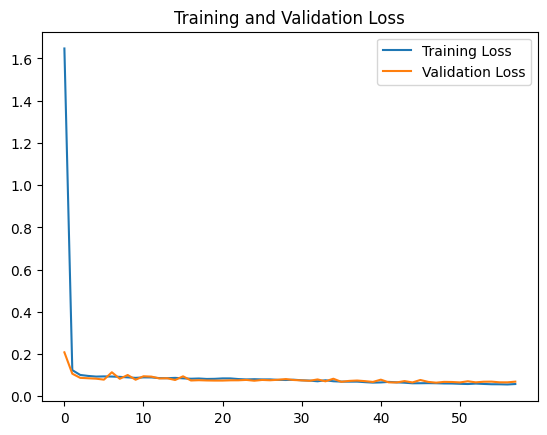

In [43]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

In [44]:
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


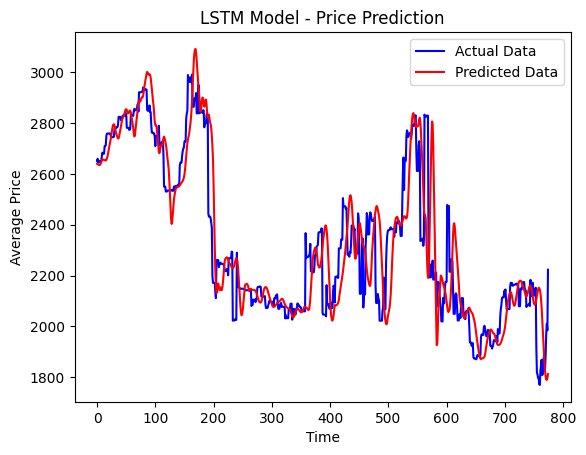

In [45]:
import matplotlib.pyplot as plt

plt.plot(y_test_rescaled, color='blue', label='Actual Data')
plt.plot(y_pred_rescaled, color='red', label='Predicted Data')
plt.title('LSTM Model - Price Prediction')
plt.xlabel('Time')
plt.ylabel('Average Price')
plt.legend()
plt.show()

In [46]:
num_features = 1  # 예측할 값이 하나 (평균 가격)

predicted_prices = []

# 현재 데이터를 시계열 입력 형식으로 변환 (현재 마지막 값 이후로 예측을 시작)
current_input = X_test[-1].reshape(1, time_step, num_features)

In [47]:
# 30일 예측
future_days = 30  # 예측할 기간 설정

for _ in range(future_days):
    # 예측값을 얻음 (모델의 출력값은 (1, 1) 형태)
    next_day_pred = model.predict(current_input)

    # 예측값을 predicted_prices 리스트에 추가
    predicted_prices.append(next_day_pred[0, 0])

    # 예측값을 current_input에 추가하여, 다음 예측에 사용
    # 예측된 값을 current_input의 마지막 값에 추가하고, 가장 첫 값을 버림
    current_input = np.append(current_input[:, 1:, :], next_day_pred.reshape(1, 1, 1), axis=1)

# 예측된 30일 가격 출력
print("Predicted 30 days prices:", predicted_prices)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

In [48]:
# 1D 배열을 2D 배열로 변환
predicted_prices = np.array(predicted_prices).reshape(-1, 1)
predicted_prices = scaler.inverse_transform(predicted_prices)

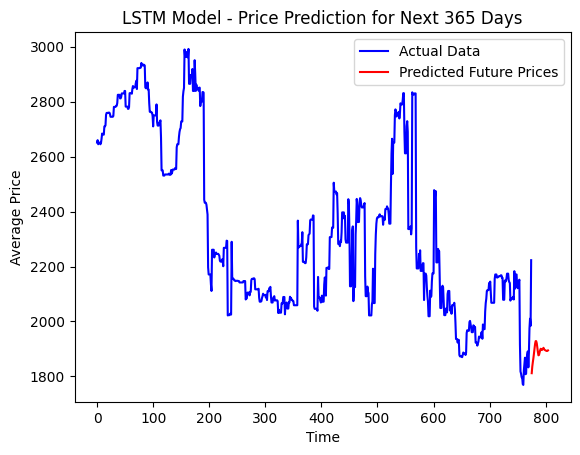

In [49]:
plt.plot(range(len(y_test_rescaled)), y_test_rescaled, color='blue', label='Actual Data')
plt.plot(range(len(y_test_rescaled), len(y_test_rescaled) + future_days), predicted_prices, color='red', label='Predicted Future Prices')
plt.title('LSTM Model - Price Prediction for Next 365 Days')
plt.xlabel('Time')
plt.ylabel('Average Price')
plt.legend()
plt.show()

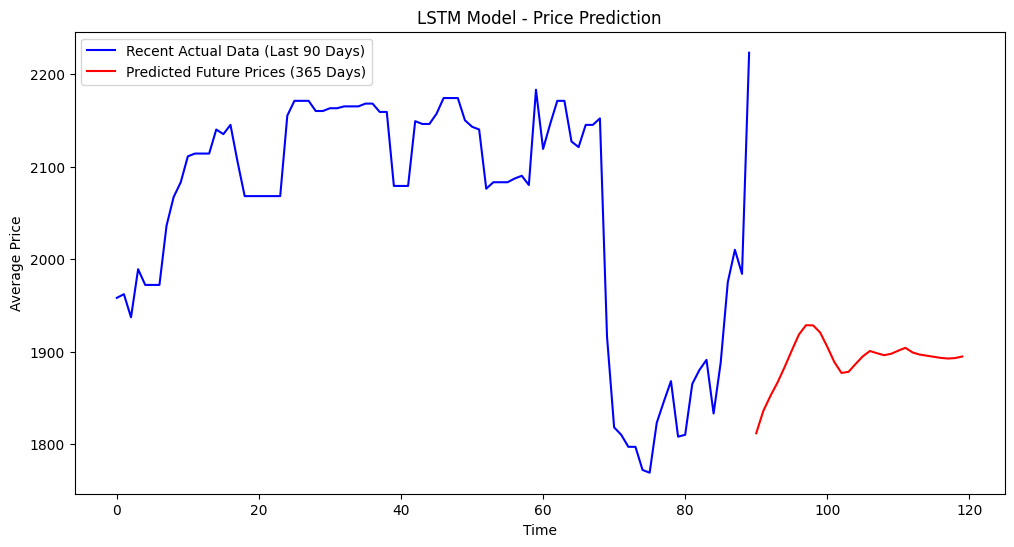

In [50]:
recent_days = 90
recent_actual_data = y_test_rescaled[-recent_days:]  # 최근 90일 데이터

# x축 범위 생성
x_actual = range(len(recent_actual_data))  # 최근 데이터의 x축
x_predicted = range(len(recent_actual_data), len(recent_actual_data) + future_days)  # 예측 데이터의 x축

# 그래프 생성
plt.figure(figsize=(12, 6))
plt.plot(x_actual, recent_actual_data, color='blue', label='Recent Actual Data (Last 90 Days)')
plt.plot(x_predicted, predicted_prices, color='red', label='Predicted Future Prices (365 Days)')
plt.title('LSTM Model - Price Prediction')
plt.xlabel('Time')
plt.ylabel('Average Price')
plt.legend()
plt.show()

In [51]:
from datetime import datetime, timedelta

onion=onion.reset_index()
onion['평균'].iloc[-1]
last_date = pd.to_datetime(onion['구분'].iloc[-1])  # Potato DataFrame에서 마지막 날짜 추출
last_price =onion['평균'].iloc[-1]  # Potato DataFrame에서 마지막 가격 추출

# 날짜 생성
future_dates = [last_date + timedelta(days=i+1) for i in range(len(predicted_prices))]

# DataFrame 생성

df_0 = pd.DataFrame({
    '날짜': [last_date],
    '예측가격': [last_price]
})
df_future = pd.DataFrame({
    '날짜': future_dates,
    '예측가격': predicted_prices.flatten()  # 배열을 1차원으로 변환
})

df_onion_extended=pd.concat([df_0, df_future], ignore_index=True)
df_onion_extended['품목'] = '양파'

# CSV로 저장
output_path = "onion_predictions.csv"
df_onion_extended.to_csv(output_path, index=False, encoding='cp949')


## --------- 오이 LSTM ------------------

In [ ]:
cucumber = pd.read_csv('/content/sample_data/품목_소매가_전부_갱신.csv', encoding='cp949') ### 추가, 변경
cucumber = cucumber[cucumber['품목']=='오이'].drop(columns='품목')  ### 추가, 변경
cucumber.head()


,구분,평균,전통시장,유통업체
51727,2014-01-02,"10,572","6,832","12,010"
51728,2014-01-03,"10,551","6,832","12,101"
51729,2014-01-04,"10,551","6,832","12,101"
51730,2014-01-05,"10,551","6,832","12,101"
51731,2014-01-06,"10,610","7,032","12,101"


In [ ]:
cucumber = cucumber.drop(cucumber.columns[2:], axis = 1)
cucumber['평균'] = cucumber['평균'].str.replace(',', '').astype(float)
cucumber.head()

,구분,평균
51727,2014-01-02,10572.0
51728,2014-01-03,10551.0
51729,2014-01-04,10551.0
51730,2014-01-05,10551.0
51731,2014-01-06,10610.0


In [ ]:
cucumber['구분'] = pd.to_datetime(cucumber['구분'])

cucumber.set_index('구분', inplace=True)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(cucumber)

scaled_data = pd.DataFrame(scaled_data, columns=['평균'], index=cucumber.index)

scaled_data

,평균
구분,
2014-01-02,0.303608
2014-01-03,0.302557
2014-01-04,0.302557
2014-01-05,0.302557
2014-01-06,0.305510
...,...
2024-11-29,0.675124
2024-12-02,0.671371
2024-12-03,0.668018


In [ ]:
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size

train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

def create_dataset(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data.iloc[i:i + time_step].values)  # time_step만큼의 데이터를 X로 사용
        y.append(data.iloc[i + time_step].values)  # 그 다음 시점의 데이터를 y로 사용
    return np.array(X), np.array(y)

# 시계열 데이터를 X, y 형식으로 변환
time_step = 25  # 시계열 길이(바꾸는 것)
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [ ]:
# 모델 구성
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

model = Sequential()

# 첫 번째 LSTM 층
model.add(LSTM(100, activation='tanh', return_sequences=True,
               kernel_regularizer=l2(0.01), input_shape=(X_train.shape[1], 1)))
# Dropout
model.add(Dropout(0.2))


# 두 번째 LSTM 층
model.add(LSTM(200, activation='tanh', return_sequences=True,
               kernel_regularizer=l2(0.01)))
# Dropout
model.add(Dropout(0.2))


# 세 번째 LSTM 층
model.add(LSTM(50, activation='tanh', return_sequences=True,
               kernel_regularizer=l2(0.01)))
# Dropout
model.add(Dropout(0.2))


# 네 번째 LSTM 층
model.add(LSTM(50, activation='tanh', return_sequences=True,
               kernel_regularizer=l2(0.01)))
# Dropout
model.add(Dropout(0.2))


# 마지막 LSTM 층
model.add(LSTM(100, activation='tanh', return_sequences=True,
               kernel_regularizer=l2(0.01)))
# Dropout
model.add(Dropout(0.2))

model.add(LSTM(200, activation='tanh', return_sequences=False,
               kernel_regularizer=l2(0.01)))
# Dropout
model.add(Dropout(0.2))


# 출력층 (예측할 값은 하나이므로 유닛 1)
model.add(Dense(1))

# 모델 요약
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_36 (LSTM)                       │ (None, 18, 100)             │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 18, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_37 (LSTM)                       │ (None, 18, 100)             │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_37 (Dropout)                 │ (None, 18, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_38 (LSTM)                       │ (None, 18, 50)              │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_38 (Dropout)                 │ (None, 18, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_39 (LSTM)                       │ (None, 18, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_39 (Dropout)                 │ (None, 18, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_40 (LSTM)                       │ (None, 18, 100)             │          60,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_40 (Dropout)                 │ (None, 18, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_41 (LSTM)                       │ (None, 200)                 │         240,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_41 (Dropout)                 │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │             201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 473,001 (1.80 MB)

 Trainable params: 473,001 (1.80 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.0009), loss=rmse, metrics=['mae'])

# EarlyStopping 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size=25, # (바꾸는 것)
                    epochs=100,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

Epoch 1/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 3.2789 - mae: 0.1105 - val_loss: 0.2410 - val_mae: 0.1212
Epoch 2/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.1618 - mae: 0.0778 - val_loss: 0.1632 - val_mae: 0.1317
Epoch 3/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.1156 - mae: 0.0775 - val_loss: 0.1508 - val_mae: 0.1214
Epoch 4/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.1102 - mae: 0.0744 - val_loss: 0.1524 - val_mae: 0.1244
Epoch 5/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.1097 - mae: 0.0745 - val_loss: 0.1551 - val_mae: 0.1296
Epoch 6/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.1094 - mae: 0.0756 - val_loss: 0.1579 - val_mae: 0.1341
Epoch 7/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.1094 - mae: 0.0763 - val_loss: 0.1565 - val_mae: 0.1324
Epoch 8/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.1045 - mae: 0.0727 - val_loss: 0.1582 - val_mae: 0.1345
Epoch 9/100
127/127 ━━━━━━━━━━━━━━━━━━━━

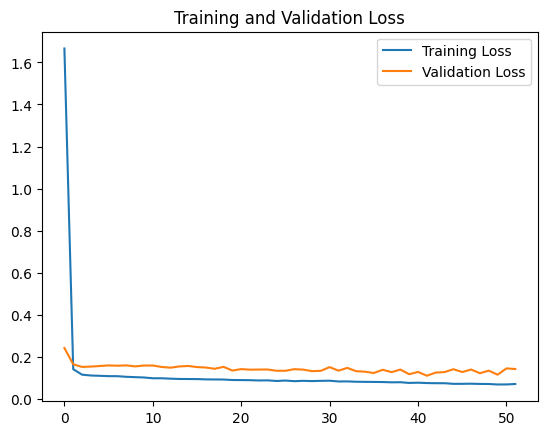

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

In [ ]:
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


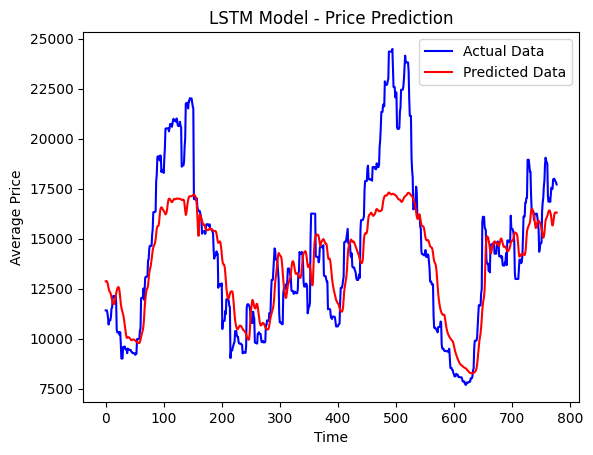

In [ ]:
import matplotlib.pyplot as plt

plt.plot(y_test_rescaled, color='blue', label='Actual Data')
plt.plot(y_pred_rescaled, color='red', label='Predicted Data')
plt.title('LSTM Model - Price Prediction')
plt.xlabel('Time')
plt.ylabel('Average Price')
plt.legend()
plt.show()

In [ ]:
num_features = 1  # 예측할 값이 하나 (평균 가격)

predicted_prices = []

# 현재 데이터를 시계열 입력 형식으로 변환 (현재 마지막 값 이후로 예측을 시작)
current_input = X_test[-1].reshape(1, time_step, num_features)

In [ ]:
# 30일 예측
future_days = 30  # 예측할 기간 설정

for _ in range(future_days):
    # 예측값을 얻음 (모델의 출력값은 (1, 1) 형태)
    next_day_pred = model.predict(current_input)

    # 예측값을 predicted_prices 리스트에 추가
    predicted_prices.append(next_day_pred[0, 0])

    # 예측값을 current_input에 추가하여, 다음 예측에 사용
    # 예측된 값을 current_input의 마지막 값에 추가하고, 가장 첫 값을 버림
    current_input = np.append(current_input[:, 1:, :], next_day_pred.reshape(1, 1, 1), axis=1)

# 예측된 30일 가격 출력
print("Predicted 30 days prices:", predicted_prices)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

In [ ]:
# 1D 배열을 2D 배열로 변환
predicted_prices = np.array(predicted_prices).reshape(-1, 1)
predicted_prices = scaler.inverse_transform(predicted_prices)

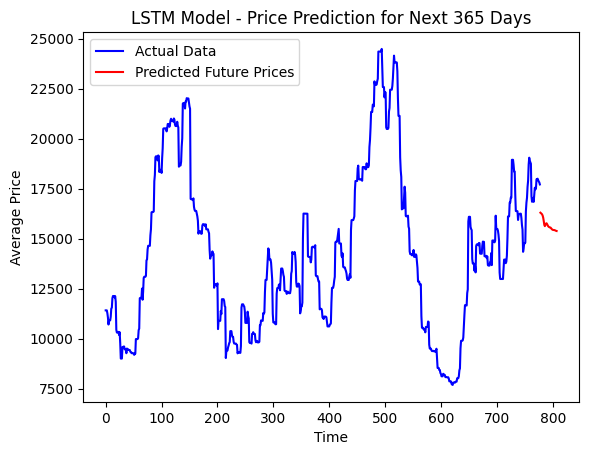

In [ ]:
plt.plot(range(len(y_test_rescaled)), y_test_rescaled, color='blue', label='Actual Data')
plt.plot(range(len(y_test_rescaled), len(y_test_rescaled) + future_days), predicted_prices, color='red', label='Predicted Future Prices')
plt.title('LSTM Model - Price Prediction for Next 365 Days')
plt.xlabel('Time')
plt.ylabel('Average Price')
plt.legend()
plt.show()

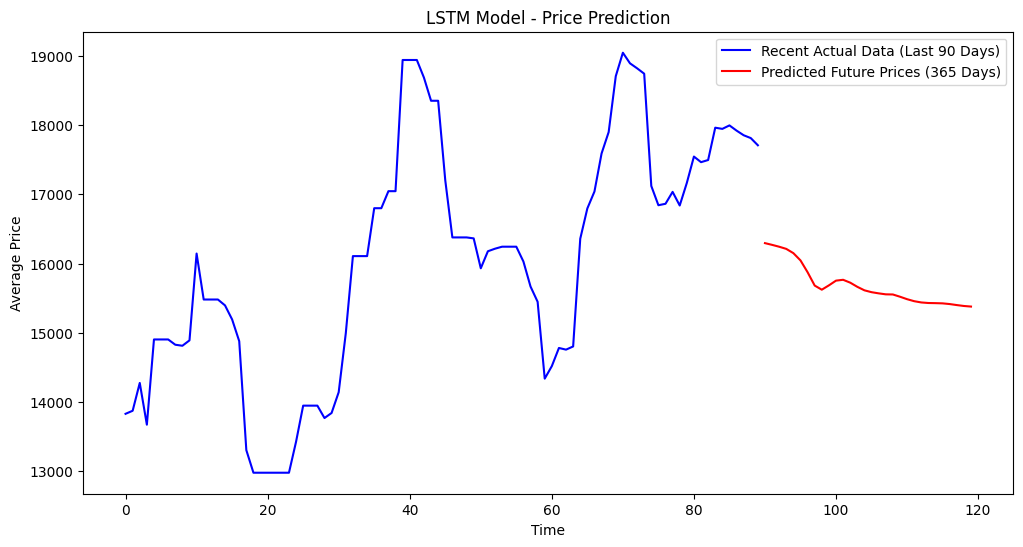

In [ ]:
recent_days = 90
recent_actual_data = y_test_rescaled[-recent_days:]  # 최근 90일 데이터

# x축 범위 생성
x_actual = range(len(recent_actual_data))  # 최근 데이터의 x축
x_predicted = range(len(recent_actual_data), len(recent_actual_data) + future_days)  # 예측 데이터의 x축

# 그래프 생성
plt.figure(figsize=(12, 6))
plt.plot(x_actual, recent_actual_data, color='blue', label='Recent Actual Data (Last 90 Days)')
plt.plot(x_predicted, predicted_prices, color='red', label='Predicted Future Prices (365 Days)')
plt.title('LSTM Model - Price Prediction')
plt.xlabel('Time')
plt.ylabel('Average Price')
plt.legend()
plt.show()

In [ ]:
from datetime import datetime, timedelta

cucumber=cucumber.reset_index()
cucumber['평균'].iloc[-1]
last_date = pd.to_datetime(cucumber['구분'].iloc[-1])  # Potato DataFrame에서 마지막 날짜 추출
last_price =cucumber['평균'].iloc[-1]  # Potato DataFrame에서 마지막 가격 추출

# 날짜 생성
future_dates = [last_date + timedelta(days=i+1) for i in range(len(predicted_prices))]

# DataFrame 생성

df_0 = pd.DataFrame({
    '날짜': [last_date],
    '예측가격': [last_price]
})
df_future = pd.DataFrame({
    '날짜': future_dates,
    '예측가격': predicted_prices.flatten()  # 배열을 1차원으로 변환
})

df_cucumber_extended=pd.concat([df_0, df_future], ignore_index=True)
df_cucumber_extended['품목'] = '오이'

# CSV로 저장
output_path = "cucumber_predictions.csv"
df_cucumber_extended.to_csv(output_path, index=False, encoding='cp949')
